### Mahmut Furkan Gön   furkan.gon@bilkent.edu.tr   21902582

# CS533 HW1

In this assignment, you will implement an information retrieval system using a combination of traditional
retrieval methods and word embeddings. Specifically, you will be integrating TF-IDF and BM25 ranking
methods with FastText embeddings. 

- Your task involves three different cases for using FastText: 

    (1) training a FastText model from scratch on the CISI dataset, 

    (2) using a pre-trained FastText model, and 

    (3) fine-tuning a pre-trained FastText model on the CISI dataset. 
    
- You will rank documents for the given queries based on a combination of their traditional retrieval scores and the similarity between their embedding vectors. The performance of your retrieval system will be evaluated using the Mean Average Precision (MAP) metric.

## Part 1: Dataset Preprocessing

* Load the CISI dataset from the provided CSV files. The dataset consists of:
    
    Documents: Represented by document id, title, and text.

    Queries: List of natural language questions represented by query ids and texts.
    
    Ground Truth: Contains relevance judgments for query-document pairs.

* Preprocess the dataset. This may include tokenizing the text, removing stopwords and punctuation marks, and lowercasing the text. Explain your preprocessing steps.

In [1]:
import numpy as np
import pandas as pd
import os
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from gensim.models import FastText, KeyedVectors
import fasttext
from RetrievalSystem import *
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# Define the paths
base_path = os.getcwd()
cisi_path = os.path.join(base_path, "CISI")

# Load the datasets
documents = pd.read_csv(os.path.join(cisi_path, "documents.csv"))
queries = pd.read_csv(os.path.join(cisi_path, "queries.csv"))
ground_truth = pd.read_csv(os.path.join(cisi_path, "ground_truth.csv"))

# Print data summaries
print("Documents:")
print(documents.head())
print("\nQueries:")
print(queries.head())
print("\nGround Truth:")
print(ground_truth.head())

Documents:
   Unnamed: 0  doc_id                                             title  \
0           0       1  18 Editions of the Dewey Decimal Classifications   
1           1       2                                               NaN   
2           2       3                                Two Kinds of Power   
3           3       4        Systems Analysis of a University Library;    
4           4       5                        A Library Management Game:   

           author                                               text  
0  Comaromi, J.P.     The present study is a history of the DEWEY...  
1             NaN  This report is an analysis of 6300 acts of use...  
2      Wilson, P.      The relationships between the organization...  
3  Buckland, M.K.      The establishment of nine new universities...  
4      Brophy, P.      Although the use of games in professional ...  

Queries:
   Unnamed: 0  query_id                                               text
0           0         1  Wh

In [46]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mahmu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahmu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mahmu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mahmu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [47]:
def preprocess_text(text):
    # Ensure the input is a string, else return an empty string
    if not isinstance(text, str):
        return ""
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenizing
    tokens = word_tokenize(text)
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a single string
    return ' '.join(tokens)


In [48]:
# Apply preprocessing to the text column
documents['processed_text'] = documents['text'].apply(preprocess_text)
queries['processed_text'] = queries['text'].apply(preprocess_text)

# View the processed data
print(documents.head())
print("------------------------------")
print(queries.head)

   Unnamed: 0  doc_id                                             title  \
0           0       1  18 Editions of the Dewey Decimal Classifications   
1           1       2                                               NaN   
2           2       3                                Two Kinds of Power   
3           3       4        Systems Analysis of a University Library;    
4           4       5                        A Library Management Game:   

           author                                               text  \
0  Comaromi, J.P.     The present study is a history of the DEWEY...   
1             NaN  This report is an analysis of 6300 acts of use...   
2      Wilson, P.      The relationships between the organization...   
3  Buckland, M.K.      The establishment of nine new universities...   
4      Brophy, P.      Although the use of games in professional ...   

                                      processed_text  
0  present study history dewey decimal classifica...  
1  rep

In [49]:
print(documents[documents['processed_text'] == ""])

     Unnamed: 0  doc_id                      title             author text  \
790         790     791  Progress in Documentation  Fairthorne, R.A.   NaN   

    processed_text  
790                 



## Part 2: Word Embedding

In [50]:
def tokenize_text(text):
    return word_tokenize(text) if isinstance(text, str) else []

In [51]:
# Tokenize documents
document_sentences = documents['processed_text'].apply(tokenize_text).tolist()

# Tokenize queries
query_sentences = queries['text'].apply(preprocess_text).apply(tokenize_text).tolist()

# Combine sentences from both documents and queries
all_sentences = document_sentences + query_sentences

# Flatten nested lists and remove empty sentences
all_sentences = [" ".join(sentence) for sentence in all_sentences if sentence]

# Save tokenized sentences to a training text file
training_file_path = "fasttext_cisi_training.txt"
with open(training_file_path, "w", encoding="utf-8") as f:
    for sentence in all_sentences:
        f.write(sentence + "\n")


### 2.1 Training FastText:
Use the gensim library to train a FastText model on the CISI dataset. Ensure that both the text from the queries and the documents are used for the training process. This approach will help the model learn the specific vocabulary and context present in the dataset.

To reproduce the model, please uncomment the following cell.

In [52]:
# # Train FastText model using the fasttext library
# fasttext_model = fasttext.train_unsupervised(
#     input=training_file_path,  # Path to the training file
#     model="skipgram",          # Skip-gram model (use 'cbow' for CBOW)
#     dim=300,                   # Dimensionality of the embeddings
#     ws=5,                      # Context window size
#     minCount=2,                # Minimum word count threshold
#     epoch=100                   # Number of training epochs
# )

# # Save the trained FastText model in binary format
# model_save_path = "fasttext_cisi_model.bin"
# fasttext_model.save_model(model_save_path)

# print(f"FastText model trained and saved to {model_save_path}")

In [53]:
fasttext_model_path = os.path.join(base_path, "fasttext_cisi_model.bin")
fasttext_model = fasttext.load_model(fasttext_model_path)
print("FastText model from scratch loaded successfully!")

FastText model from scratch loaded successfully!


In [54]:
# Access vector representations
word_vector = fasttext_model.get_word_vector('example')  # Vector for the word "example"
print("Vector for 'example':", word_vector)

Vector for 'example': [ 3.73488426e-01 -8.75066668e-02 -5.29523253e-01 -1.75713375e-01
  2.19492957e-01 -1.34153247e-01  4.97042835e-02  1.30021051e-01
  2.09056810e-02 -3.91499251e-01  3.34076643e-01 -7.21039549e-02
 -3.00277006e-02  1.23829253e-01  1.90232210e-02 -1.28918916e-01
 -3.60354096e-01  2.89578080e-01 -4.07338619e-01 -4.52339612e-02
  2.32739747e-01  1.17654987e-01  1.80888265e-01  9.19014513e-02
 -1.15219854e-01  5.01771718e-02 -4.59802479e-01 -9.20371413e-02
  3.23043764e-01  3.77572477e-01 -2.07543001e-01 -3.22717756e-01
  9.38616097e-02 -1.45046875e-01 -2.46097341e-01  6.69709817e-02
  3.93111199e-01  4.30223584e-01 -1.77132070e-01 -2.34220594e-01
 -3.85633856e-01 -1.48490861e-01  5.15830457e-01 -4.22725648e-01
  1.65166304e-01  6.34325445e-01  1.54889569e-01  2.76691020e-01
 -2.07305208e-01  7.48061836e-01 -4.69270647e-01 -2.36766607e-01
 -8.76498222e-03  8.58169571e-02 -9.33733955e-02  3.78762335e-01
 -3.89369488e-01  9.09392089e-02  1.89038366e-02 -2.00076029e-01
  2

In [55]:
fasttext_model.get_nearest_neighbors('example', k=5)

[(0.5100557804107666, 'ample'),
 (0.4843447804450989, 'counterexample'),
 (0.3721335232257843, 'illustrated'),
 (0.35392239689826965, 'illustrate'),
 (0.3383273482322693, 'illustration')]

In [56]:
fasttext_model.get_nearest_neighbors('report', k=5)

[(0.5132254958152771, 'reporter'),
 (0.46106627583503723, 'reported'),
 (0.4397768974304199, 'reporting'),
 (0.33940306305885315, 'calbpc'),
 (0.3332134187221527, 'colorado')]

### 2.2 Using a Pre-trained FastText Model: 
Instead of starting from scratch, you can leverage pre-existing knowledge by using a pre-trained FastText model. Download a pre-trained FastText model, such as “cc.en.300.bin” (English), from the FastText website or using the fasttext library. The pre-trained model can be loaded using the gensim library for direct use in your retrieval system.

In [57]:
# Path to the pre-trained FastText model
pretrained_model_path = os.path.join(base_path, "cc.en.300.bin")

# Load the pre-trained FastText model
pretrained_fasttext_model = fasttext.load_model(pretrained_model_path)

print("Pre-trained FastText model loaded successfully!")

Pre-trained FastText model loaded successfully!


In [58]:
word_vector = pretrained_fasttext_model.get_word_vector('example')
print(f"Vector for 'example': {word_vector}")


Vector for 'example': [-3.01899910e-02  1.67307898e-03 -3.39188091e-02  1.29165754e-04
 -3.39024775e-02 -3.52627262e-02  5.44663481e-02 -2.15502288e-02
  1.57393347e-02 -5.50850853e-03 -9.77861509e-03  6.96822815e-03
  1.34404376e-02  4.04827148e-02 -5.77299595e-02  2.67399456e-02
  4.28873971e-02  1.72743984e-02  5.14067225e-02  4.15806361e-02
 -3.46253510e-03 -4.39561009e-02  4.55061607e-02 -4.61385176e-02
 -6.82864487e-02 -1.10961404e-02  1.33144371e-02  2.14999523e-02
  8.21126904e-03 -5.76011557e-03  1.62116960e-02  6.52960828e-03
  7.23410025e-03 -5.48320338e-02 -1.13268523e-02 -9.41580534e-03
  3.99618335e-02 -5.51603436e-02 -4.69672195e-05 -5.19470498e-02
 -3.15293521e-02 -4.06791782e-03 -5.40495440e-02 -1.99173968e-02
 -8.28304701e-03  4.20339815e-02  2.26341262e-02 -1.23577183e-02
  1.77250840e-02  2.66364366e-02  2.01242566e-02  1.41719412e-02
 -4.94768023e-02  3.80847923e-04  1.61610469e-02 -3.24339680e-02
 -5.72527312e-02 -1.43544767e-02 -1.18667241e-02 -3.18274871e-02
 -6

In [59]:
# Find similar words
pretrained_fasttext_model.get_nearest_neighbors('example', k=5)

[(0.8356781601905823, 'instance'),
 (0.7126652002334595, 'example.In'),
 (0.6859133839607239, 'exmaple'),
 (0.6804730296134949, 'example.The'),
 (0.6717150211334229, 'example.For')]

In [60]:
pretrained_fasttext_model.get_nearest_neighbors('report', k=5)

[(0.7258307337760925, 'reports'),
 (0.6820427775382996, 'report.It'),
 (0.6762813925743103, 'report.The'),
 (0.6462412476539612, 'report.In'),
 (0.627001941204071, 'report.But')]

### 2.3 Fine-tuning a Pre-trained FastText Model: 
Further improve a pre-trained FastText model by finetuning it on the CISI dataset. This involves continuing the training process using the text from both the queries and the documents, allowing the model to adapt and better capture the characteristics and domain-specific vocabulary of the dataset.

To reproduce the model, please uncomment the following cell.

In [61]:
# # Fine-tune the model on the CISI dataset
# finetuned_fasttext_model = fasttext.train_unsupervised(
#     training_file_path, model="skipgram",  # Use the Skip-gram approach
#     dim=300,                              # Keep the same dimension as the pre-trained model
#     ws=5,                                 # Window size
#     epoch=100,                             # Number of epochs for fine-tuning
#     lr=0.05                               # Learning rate
# )

# # Save the fine-tuned model
# finetuned_fasttext_model.save_model("finetuned_fasttext_cisi.bin")
# print("Fine-tuned FastText model saved successfully!")

In [62]:
# Path to the pre-trained FastText model
finetuned_model_path = os.path.join(base_path, "finetuned_fasttext_cisi.bin")

# Load the pre-trained FastText model
finetuned_fasttext_model = fasttext.load_model(finetuned_model_path)

print("Finetuned FastText model loaded successfully!")

Finetuned FastText model loaded successfully!


In [63]:
word_vector = finetuned_fasttext_model.get_word_vector('example')
print(f"Vector for 'example': {word_vector}")

Vector for 'example': [-3.30511387e-03  1.92290366e-01 -2.72896975e-01 -1.61886945e-01
  1.93295777e-01 -2.46024337e-02 -1.15158737e-01  9.89866257e-03
 -2.55941242e-01  4.91797589e-02 -1.09414890e-01  3.69632363e-01
 -1.43140078e-01  8.74954741e-03 -7.08084255e-02  1.05372168e-01
  4.10697460e-01 -3.44208889e-02  4.15693581e-01  3.32161129e-01
 -2.22472027e-01  9.54589099e-02 -1.13886446e-02  1.35404542e-01
  1.04565717e-01 -9.15621817e-02  6.64883340e-03  2.58368313e-01
 -3.98590267e-01 -2.19972342e-01 -1.18567169e-01 -4.49383497e-01
  4.01225351e-02  2.99022496e-01 -1.72159001e-02  1.53683066e-01
  9.12302509e-02  1.83047831e-01  5.65183796e-02 -8.50482434e-02
  1.76456884e-01  6.73112050e-02  9.24901962e-02 -6.14280403e-02
  2.99793154e-01  3.76103282e-01  2.22564623e-01  3.32328647e-01
 -1.31032392e-01  9.78120565e-02 -1.53861299e-01 -2.49642938e-01
  3.92234981e-01 -5.64971752e-02  3.86625081e-01 -3.68081719e-01
 -6.11007735e-02  1.43693537e-01  2.13619292e-01 -1.84827462e-01
  1

In [64]:
# Find similar words
finetuned_fasttext_model.get_nearest_neighbors('example', k=5)

[(0.367607980966568, 'illustrate'),
 (0.3661535680294037, 'illustrated'),
 (0.35254397988319397, 'illustration'),
 (0.2958385646343231, 'illustrative'),
 (0.27807554602622986, 'deriving')]

In [65]:
# Find similar words
finetuned_fasttext_model.get_nearest_neighbors('report', k=5)

[(0.4423002302646637, 'reported'),
 (0.4082240164279938, 'reporting'),
 (0.2666744589805603, 'colorado'),
 (0.26529040932655334, 'study'),
 (0.263837993144989, 'federal')]

## Part 3: Retrieval Task
In this part, you will focus on the core of information retrieval: fetching relevant documents based on a user's
query. The challenge lies in effectively combining traditional retrieval methods with modern word embeddings
to enhance the accuracy of the results.

### 3.1 Embedding Computation: 
Implement a method to derive the embedding for an input (a query or a document) by averaging the embeddings of its constituent words.

In [66]:
def get_sentence_embedding(sentence, model):
    # Tokenize the input sentence
    words = tokenize_text(sentence)
    
    # Retrieve embeddings for words in the model's vocabulary
    word_vectors = []
    for word in words:
        if word in model:  # Check if the word is in the model's vocabulary
            word_vectors.append(model[word])
    
    if not word_vectors:
        # If no words are found in the model, return a zero vector
        return np.zeros(model.get_dimension())
    
    # Compute the average of the embeddings
    return np.mean(word_vectors, axis=0)

In [67]:
query_embedding = get_sentence_embedding(queries.iloc[0]['text'], finetuned_fasttext_model)
document_embedding = get_sentence_embedding(documents.iloc[0]['text'], finetuned_fasttext_model)
print("Query Embedding:", query_embedding)
print("Document Embedding:", document_embedding)

Query Embedding: [ 0.21536903  0.23669423 -0.0640805   0.11348046  0.19875145 -0.07564321
 -0.0101939   0.03241597  0.01711885 -0.29355258 -0.00544521  0.3331181
 -0.21353722 -0.0114033  -0.11476514  0.39784744 -0.06138306  0.10508697
 -0.03888498 -0.10939223  0.12638661  0.15492316  0.06671454  0.01158551
 -0.10143891 -0.0971714   0.07688447  0.17311682  0.18390515 -0.0824891
  0.28280097 -0.07715379  0.00267974 -0.1333955  -0.14088164  0.12647456
  0.24772088  0.05238817 -0.06896492  0.05658883  0.0213083   0.15433237
 -0.0832986   0.32549417  0.22824675  0.17269982  0.07268713  0.0199539
 -0.13203736  0.27837053  0.08034511  0.06946759 -0.02599566  0.07729217
 -0.02160507 -0.21435943 -0.09080509  0.04511565  0.3319394   0.26765263
  0.26620218 -0.16779032  0.0214179  -0.01002946  0.08650747  0.2580381
  0.01595108 -0.01960871  0.04059663 -0.18078959  0.12327419  0.04928033
 -0.0080447   0.16983777 -0.34888232  0.2146839   0.24137242  0.07682027
 -0.07245657 -0.09041765 -0.01922172  

### 3.2 Retrieval System

Construct a retrieval system that:

- Retrieves the top 10 documents for a given query.
- Combines scores from TF-IDF, BM25, and word embeddings to rank documents. You can use TfidfVectorizer from sklearn.feature_extraction.text, and BM25Okapi from rank_bm25 to obtain the TFIDF and BM25 scores. Use cosine similarity to calculate the embedding scores. The overall score for a query-document pair is calculated as the weighted average of the TF-IDF, BM25, and embedding scores.
- Allows for the utilization of three FastText models: 
    - (1) the FastText model you trained from scratch on the CISI dataset, 
    - (2) a pre-trained FastText model, and 
    - (3) the fine-tuned version of the pre-trained model using the CISI dataset.
- Provides the flexibility to set weights for TF-IDF, BM25, and embedding scores to compute a combined score.

In [68]:
# Define models
fasttext_models = {
    'scratch': fasttext_model,  
    'pretrained': pretrained_fasttext_model,
    'finetuned': finetuned_fasttext_model
}

# Initialize retrieval system
retrieval_system = RetrievalSystem(documents, queries, fasttext_models)


In [69]:
def retrieve_with_query(query_text: str, tfidf_weight=0.5, bm25_weight=0.3, embedding_weight=0.2, fasttext_model_key='finetuned', top_k=10):
    # Retrieve top 10 documents
    return retrieval_system.retrieve(query_text, tfidf_weight=tfidf_weight, bm25_weight=bm25_weight, embedding_weight=embedding_weight, fasttext_model_key=fasttext_model_key, top_k=top_k)

In [70]:
# Example query
query_text = queries.iloc[111]['processed_text']

# Retrieve top 10 documents
top_docs, scores = retrieve_with_query(query_text)

# Display results
for idx, doc, score in zip(top_docs['doc_id'], top_docs['text'], scores):
    print(f"Score: {score:.4f}, Document: id: {idx}, {doc[:200]}...")

Score: 0.9889, Document: id: 503,    We present completely automatic procedures for the self-generation of  meaningful groups among the members of a document collection and for the  classification according to these groups of subseque...
Score: 0.9183, Document: id: 1419,    Large-scale, on-line information storage and retrieval systems pose numerous  problems above those encountered by smaller systems.. The more critical of these problems involve: degree of automation...
Score: 0.9048, Document: id: 564,    Starting with a collection of 405 document abstracts dealing with computers, the experiment in automatic document classification proceeds to construct an empirically based, mathematically derived c...
Score: 0.8770, Document: id: 483,    The SMART document retrieval system is used to investigate algorithms for text analysis and request searching.. Results from three document collections  indicate that word normalization is efficien...
Score: 0.8629, Document: id: 1132,    The exper

# Part 4: Evaluation
Evaluation is crucial in information retrieval to ensure that the system meets user expectations. In this part, you
will assess the performance of your retrieval system under various configurations. This includes experimenting
with different possibilities of combining FastText embeddings with traditional TF-IDF and BM25 methods, as
well as using each of them in isolation.
- Performance Metrics: Evaluate the efficacy of your retrieval system using the Mean Average Precision
(MAP) metric.
- Comparative Analysis: Contrast the performance metrics when employing the three FastText models:

    (1) the FastText model trained from scratch on the CISI dataset, 

    (2) the pre-trained FastText model, and

    (3) the fine-tuned FastText model. Analyze the potential reasons for observed differences or similarities in the results.

- Experimentation: Experiment with different combinations of weights for TF-IDF, BM25, and embedding scores. Also, test the performance of each method in isolation. Report your observations and the MAP scores for each scenario.

In [71]:
def calculate_map(queries, ground_truth, retrieval_system, tfidf_weight, bm25_weight, embedding_weight, fasttext_model_key, top_k=10):
    # Convert ground_truth to a dictionary for quick lookups
    ground_truth_dict = ground_truth.groupby('query_id')['doc_id'].apply(list).to_dict()

    total_average_precision = 0
    for query_id, query_text in zip(queries['query_id'], queries['processed_text']):
        # Get top-k results
        top_docs, _ = retrieval_system.retrieve(query_text, tfidf_weight, bm25_weight, embedding_weight, fasttext_model_key, top_k)
        
        # Get relevant documents for the query
        relevant_docs = ground_truth_dict.get(query_id, [])  # Returns an empty list if query_id is not found
        retrieved_doc_ids = top_docs['doc_id'].tolist()

        # Calculate precision@k
        precision_at_k = []
        relevant_count = 0
        for i, doc_id in enumerate(retrieved_doc_ids, start=1):
            if doc_id in relevant_docs:
                relevant_count += 1
                precision_at_k.append(relevant_count / i)
        
        # Average Precision for this query
        average_precision = sum(precision_at_k) / len(relevant_docs) if relevant_docs else 0
        total_average_precision += average_precision

    # Mean Average Precision (MAP)
    return total_average_precision / len(queries)


In [72]:
map_score = calculate_map(queries, ground_truth, retrieval_system=retrieval_system,tfidf_weight=0.4, bm25_weight=0.3, embedding_weight=0.3, fasttext_model_key='scratch', top_k=10)
map_score

0.05530321448266533

In [73]:
results = []

# Iterate over FastText models
for model_key in ['scratch', 'pretrained', 'finetuned']:
    # Test different weight combinations
    for weights in [(1, 0, 0), (0, 1, 0), (0, 0, 1), 
                    (0.0, 0.1, 0.9), (0.1, 0.1, 0.8), (0.2, 0.1, 0.7), (0.3, 0.1, 0.6), (0.4, 0.1, 0.5), 
                    (0.5, 0.1, 0.4), (0.6, 0.1, 0.3), (0.7, 0.1, 0.2), (0.8, 0.1, 0.1), (0.9, 0.1, 0.0),
                    (0.0, 0.2, 0.8), (0.1, 0.2, 0.7), (0.2, 0.2, 0.6), (0.3, 0.2, 0.5), (0.4, 0.2, 0.4),
                    (0.5, 0.2, 0.3), (0.6, 0.2, 0.2), (0.7, 0.2, 0.1), (0.8, 0.2, 0.0),
                    (0.0, 0.3, 0.7), (0.1, 0.3, 0.6), (0.2, 0.3, 0.5), (0.3, 0.3, 0.4), (0.4, 0.3, 0.3),
                    (0.5, 0.3, 0.2), (0.6, 0.3, 0.1), (0.7, 0.3, 0.0), 
                    (0.0, 0.4, 0.6), (0.1, 0.4, 0.5), (0.2, 0.4, 0.4), (0.3, 0.4, 0.3), (0.4, 0.4, 0.2),
                    (0.5, 0.4, 0.1), (0.6, 0.4, 0.0),
                    (0.0, 0.5, 0.5), (0.1, 0.5, 0.4), (0.2, 0.5, 0.3), (0.3, 0.5, 0.2), (0.4, 0.5, 0.1),
                    (0.5, 0.5, 0.0),
                    (0.0, 0.6, 0.4), (0.1, 0.6, 0.3), (0.2, 0.6, 0.2), (0.3, 0.6, 0.1), (0.4, 0.6, 0.0),
                    (0.0, 0.7, 0.3), (0.1, 0.7, 0.2), (0.2, 0.7, 0.1), (0.3, 0.7, 0.0),
                    (0.0, 0.8, 0.2), (0.1, 0.8, 0.1), (0.2, 0.8, 0.0),
                    (0.0, 0.9, 0.1), (0.1, 0.9, 0.0)]:
        
        tfidf_weight, bm25_weight, embedding_weight = weights
        map_score = calculate_map(queries, ground_truth, retrieval_system, tfidf_weight, bm25_weight, embedding_weight, model_key)
        results.append({
            'Model': model_key,
            'Weights': weights,
            'MAP': map_score
        })


In [74]:
results_df = pd.DataFrame(results)
print(results_df)

         Model          Weights       MAP
0      scratch        (1, 0, 0)  0.051066
1      scratch        (0, 1, 0)  0.051726
2      scratch        (0, 0, 1)  0.051785
3      scratch  (0.0, 0.1, 0.9)  0.055830
4      scratch  (0.1, 0.1, 0.8)  0.059342
..         ...              ...       ...
166  finetuned  (0.0, 0.8, 0.2)  0.053370
167  finetuned  (0.1, 0.8, 0.1)  0.054311
168  finetuned  (0.2, 0.8, 0.0)  0.054127
169  finetuned  (0.0, 0.9, 0.1)  0.052600
170  finetuned  (0.1, 0.9, 0.0)  0.053550

[171 rows x 3 columns]


In [76]:
# Save to a .txt file (tab-separated)
results_df.to_csv("results.txt", sep=',', index=False)


In [77]:
# Create a DataFrame for plotting
results_df['TF-IDF Weight'] = results_df['Weights'].apply(lambda x: x[0])
results_df['BM25 Weight'] = results_df['Weights'].apply(lambda x: x[1])
results_df['Embedding Weight'] = results_df['Weights'].apply(lambda x: x[2])

In [30]:
def plot_map_for_tfidf_fixed(results_df, tfidf_weight_value):
    # Filter for the fixed TF-IDF weight
    subset = results_df[results_df['TF-IDF Weight'] == tfidf_weight_value]
    model_name = results_df.iloc[2]["Model"]
    # Plot MAP against varying Embedding Weights
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=subset, x="Embedding Weight", y="MAP", hue="BM25 Weight", marker='o')
    plt.title(f"MAP for TF-IDF Weight = {tfidf_weight_value} in {model_name} model")
    plt.xlabel("Embedding Weight")
    plt.ylabel("MAP")
    plt.legend(title="BM25 Weight")
    plt.show()


In [29]:
def plot_map_for_bm25_fixed(results_df, bm25_weight_value):
    # Filter for the fixed BM25 weight
    subset = results_df[results_df['BM25 Weight'] == bm25_weight_value]
    model_name = results_df.iloc[2]["Model"]
    # Plot MAP against varying TF-IDF and Embedding Weights
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=subset, x="TF-IDF Weight", y="MAP", hue="Embedding Weight", marker='o')
    plt.title(f"MAP for BM25 Weight = {bm25_weight_value} in {model_name} model")
    plt.xlabel("TF-IDF Weight")
    plt.ylabel("MAP")
    plt.legend(title="Embedding Weight")
    plt.show()

In [28]:
def plot_map_for_embedding_fixed(results_df, embedding_weight_value):
    # Filter for the fixed embedding weight
    subset = results_df[results_df['Embedding Weight'] == embedding_weight_value]
    model_name = results_df.iloc[2]["Model"]
    # Plot MAP against varying TF-IDF and BM25 Weights
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=subset, x="TF-IDF Weight", y="MAP", hue="BM25 Weight", marker='o')
    plt.title(f"MAP for Embedding Weight = {embedding_weight_value} in {model_name} model")
    plt.xlabel("TF-IDF Weight")
    plt.ylabel("MAP")
    plt.legend(title="BM25 Weight")
    plt.show()


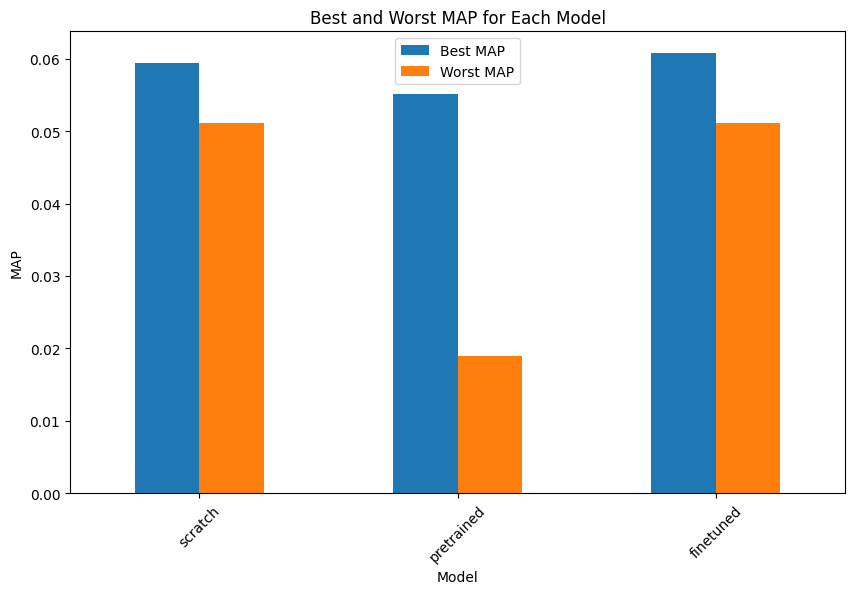

In [83]:
def best_and_worst_plots(results_df):
    best_worst_data = []

    # Group by model and find the best and worst based on MAP score
    for model_key in results_df['Model'].unique():
        model_data = results_df[results_df['Model'] == model_key]
        
        best_result = model_data.loc[model_data['MAP'].idxmax()]
        worst_result = model_data.loc[model_data['MAP'].idxmin()]
        
        best_worst_data.append({
            'Model': model_key,
            'Best MAP': best_result['MAP'],
            'Worst MAP': worst_result['MAP'],
            'Best Weights': best_result[['TF-IDF Weight', 'BM25 Weight', 'Embedding Weight']].values,
            'Worst Weights': worst_result[['TF-IDF Weight', 'BM25 Weight', 'Embedding Weight']].values
        })
    
    best_worst_df = pd.DataFrame(best_worst_data)

    # Plot the best and worst results for each model
    best_worst_df.set_index('Model')[['Best MAP', 'Worst MAP']].plot(kind='bar', figsize=(10, 6))
    plt.title("Best and Worst MAP for Each Model")
    plt.xlabel("Model")
    plt.ylabel("MAP")
    plt.xticks(rotation=45)
    plt.show()

# Example usage: Plot best and worst MAP values for each model
best_and_worst_plots(results_df)

In [2]:
results_df = pd.read_csv("results.txt")

In [ ]:
scratch_df = results_df[results_df["Model"]=="scratch"]
pretrained_df = results_df[results_df["Model"]=="pretrained"]
finetuned_df = results_df[results_df["Model"]=="finetuned"]

,Model,Weights,MAP,TF-IDF Weight,BM25 Weight,Embedding Weight
114,finetuned,"(1, 0, 0)",0.051066,1.0,0.0,0.0
115,finetuned,"(0, 1, 0)",0.051726,0.0,1.0,0.0
116,finetuned,"(0, 0, 1)",0.053462,0.0,0.0,1.0
117,finetuned,"(0.0, 0.1, 0.9)",0.058923,0.0,0.1,0.9
118,finetuned,"(0.1, 0.1, 0.8)",0.060731,0.1,0.1,0.8


In [7]:
df_list = [scratch_df, pretrained_df, finetuned_df]
weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

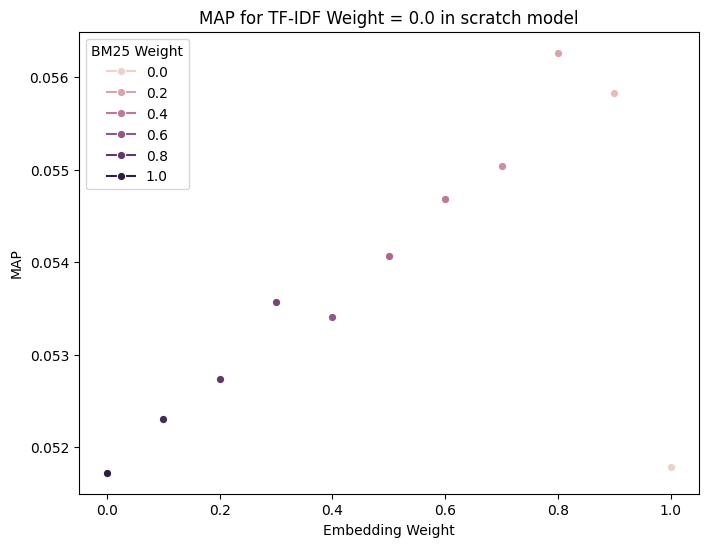

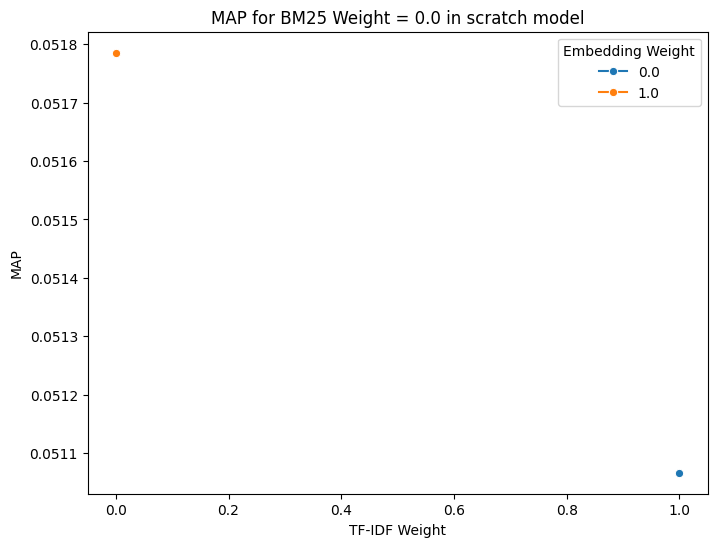

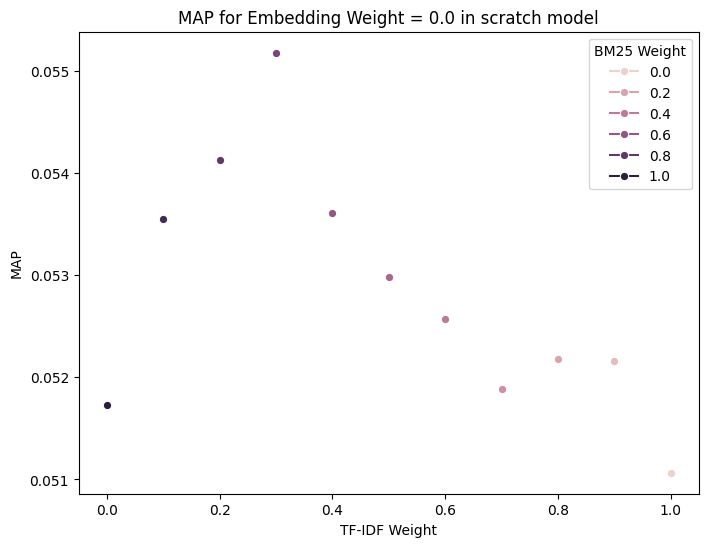

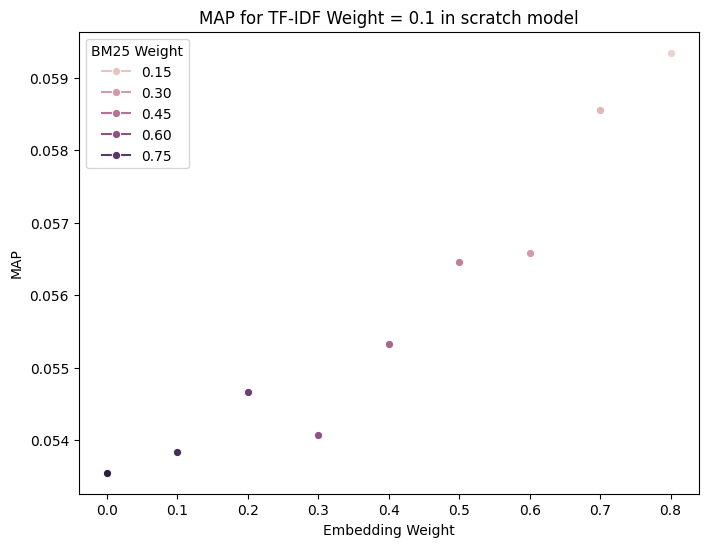

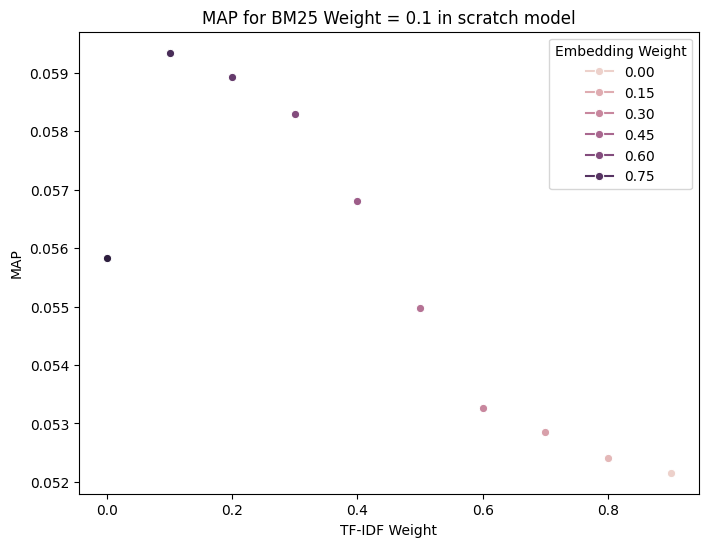

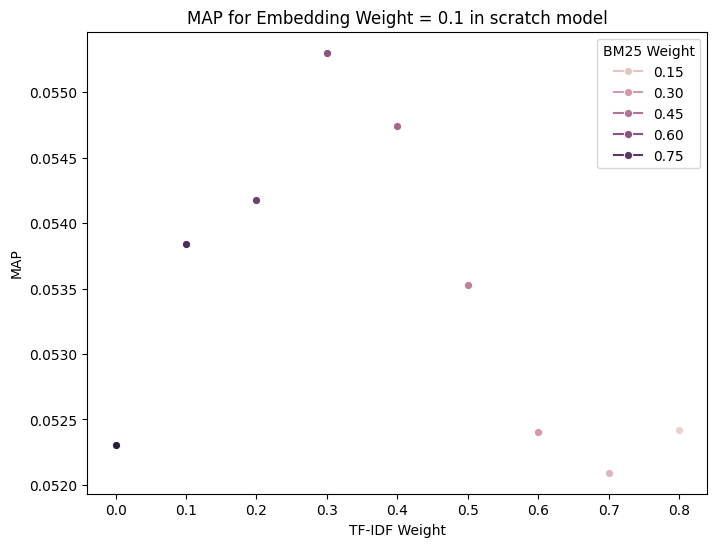

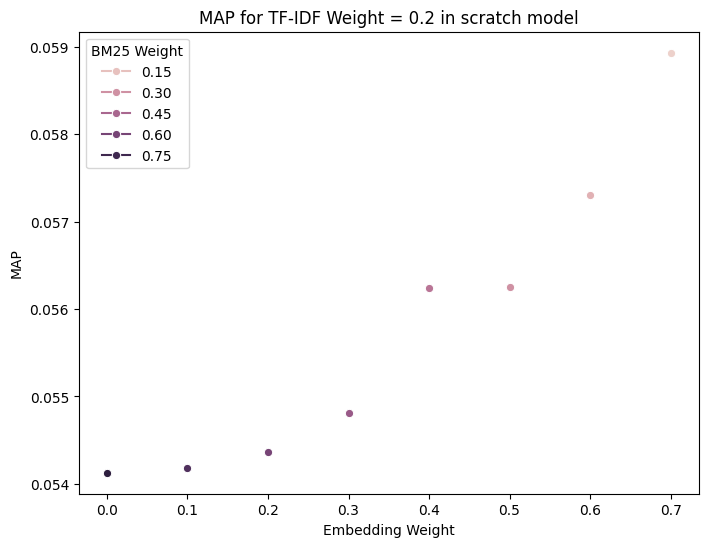

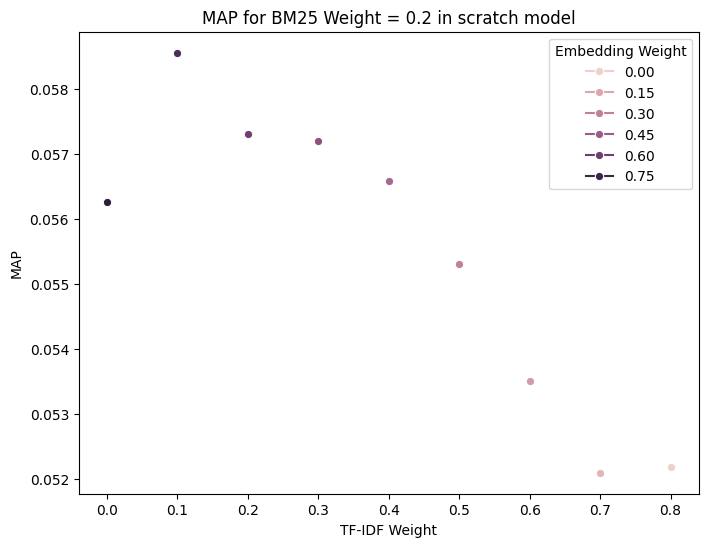

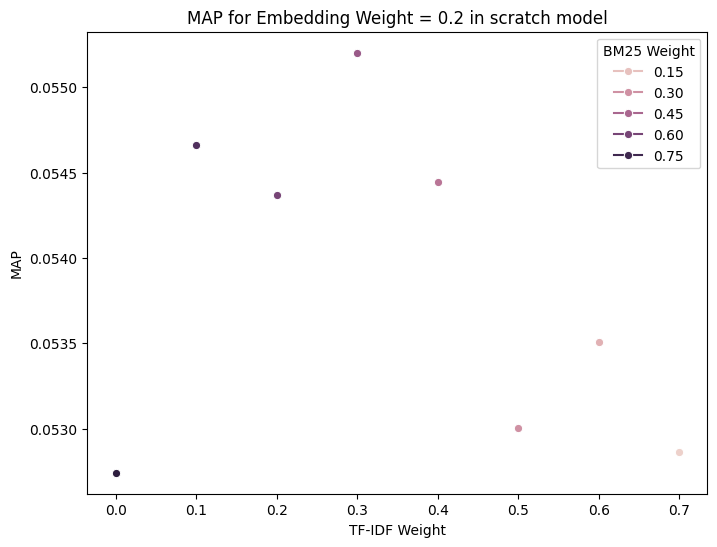

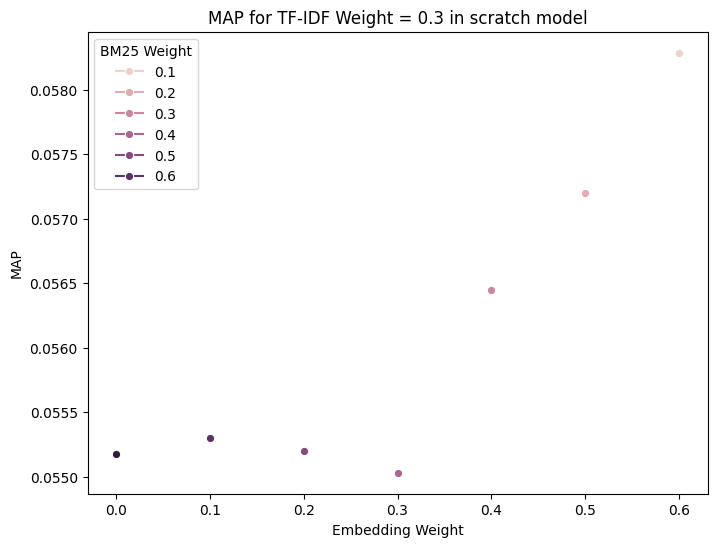

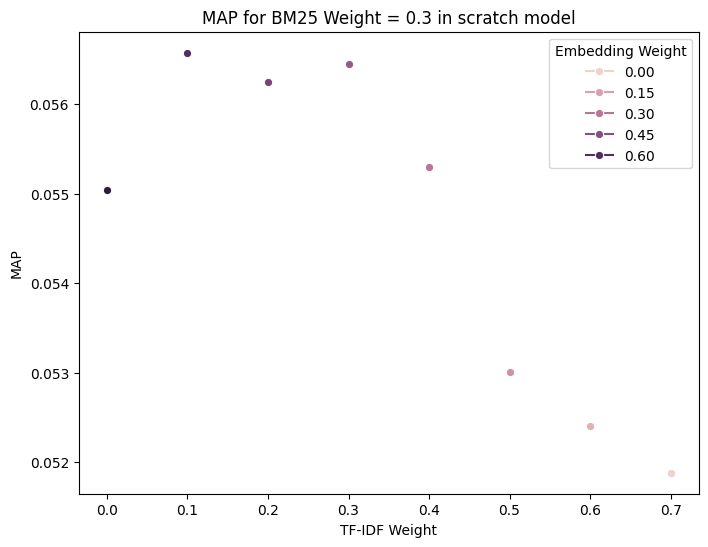

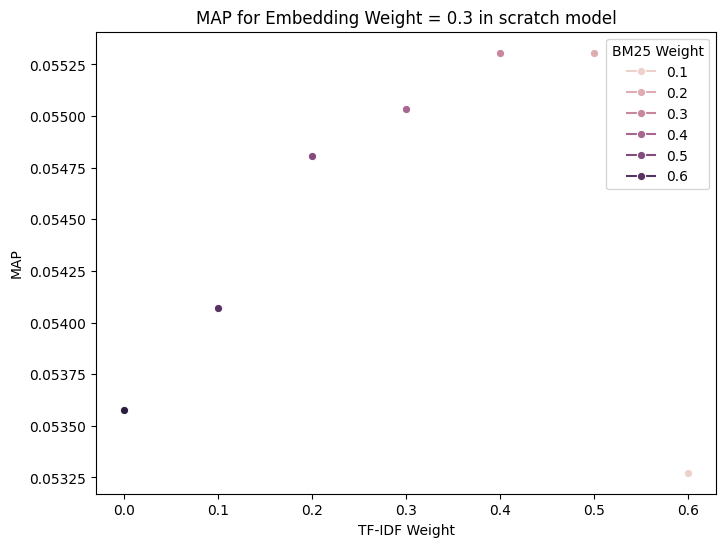

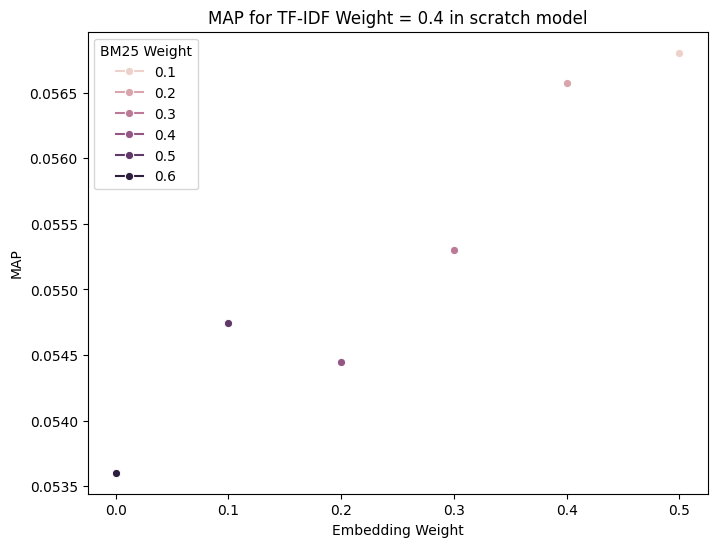

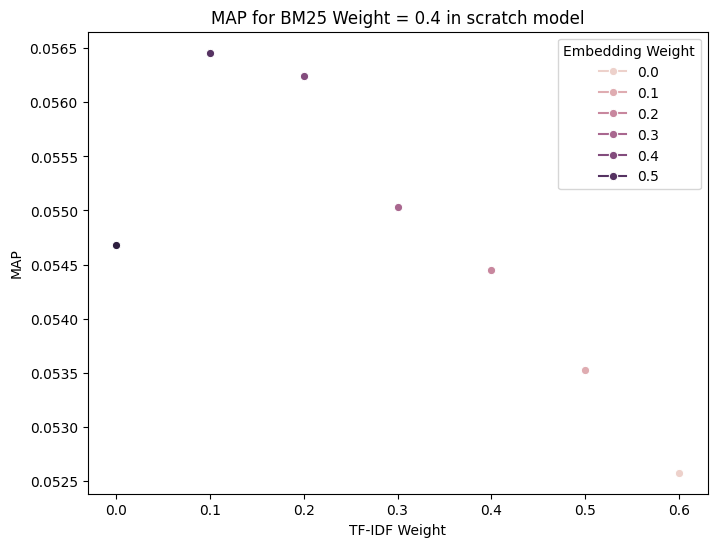

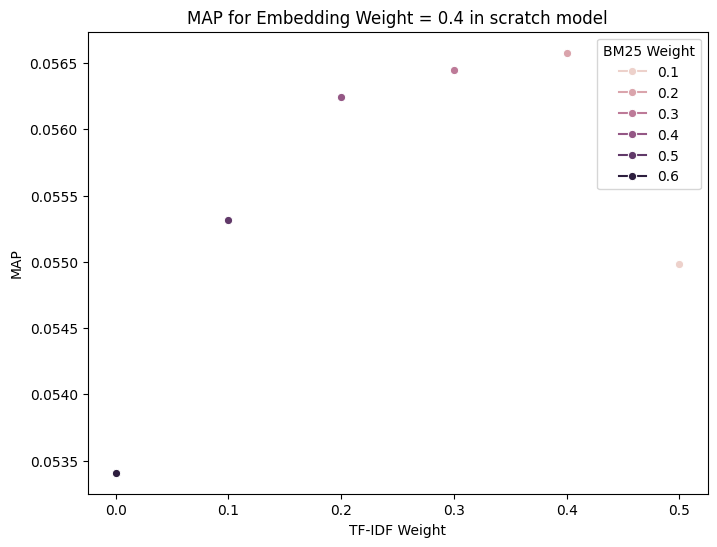

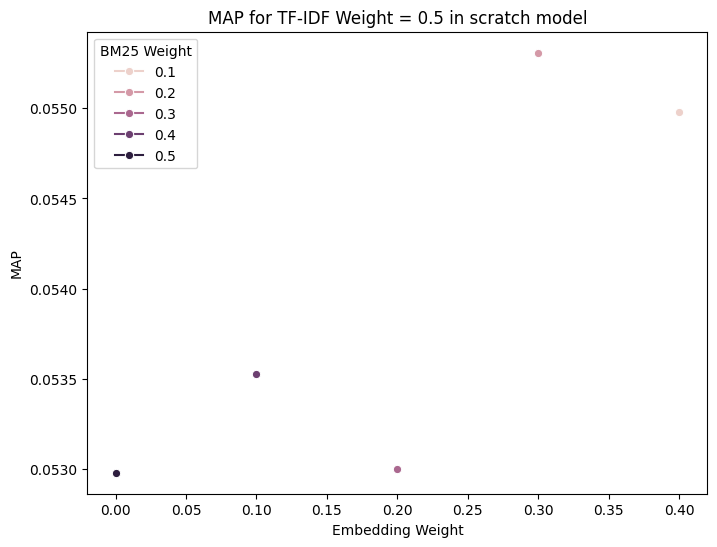

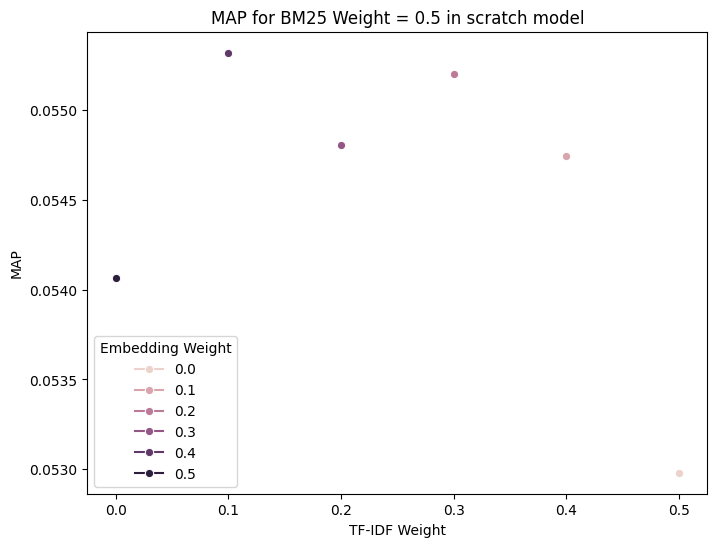

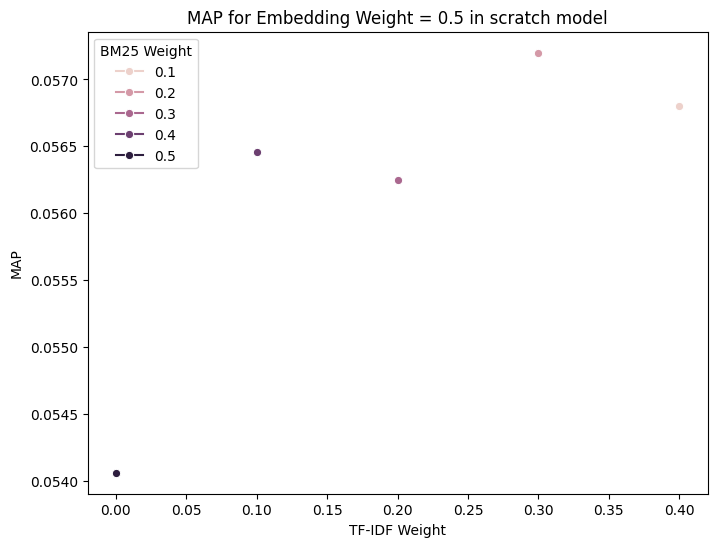

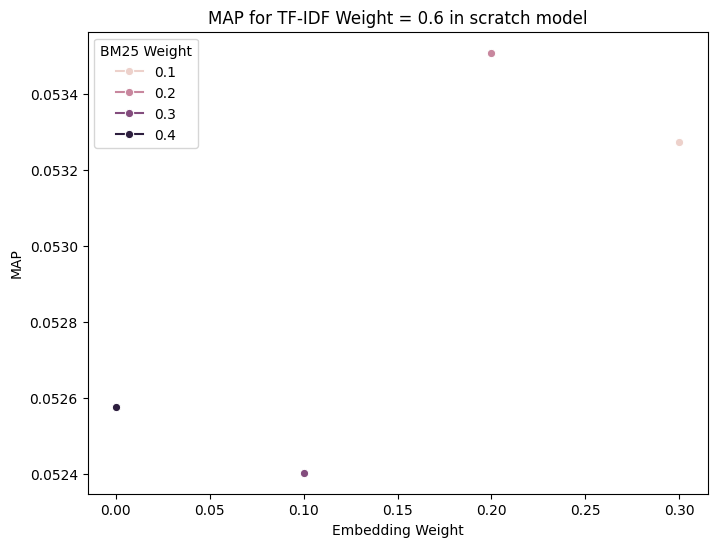

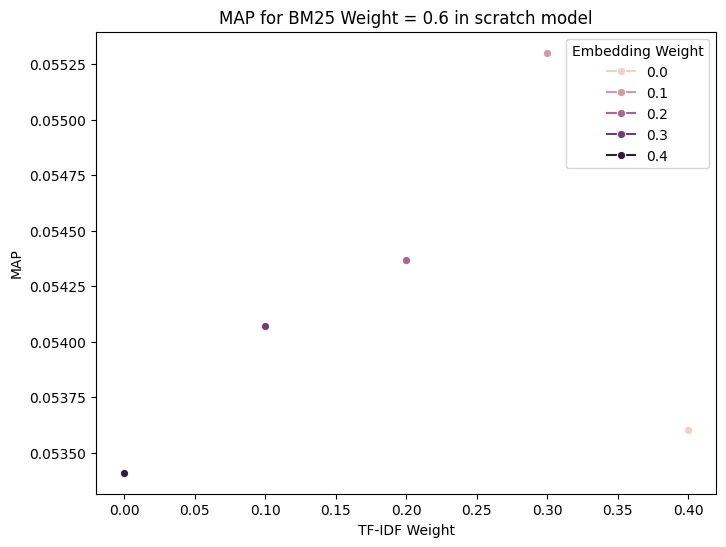

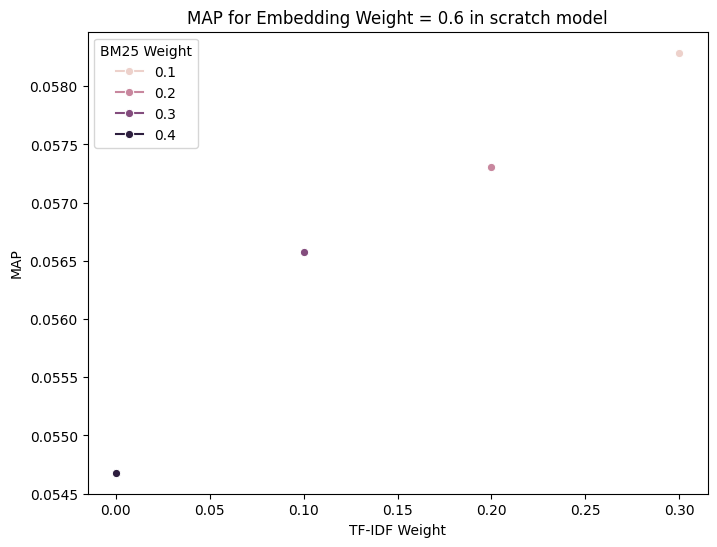

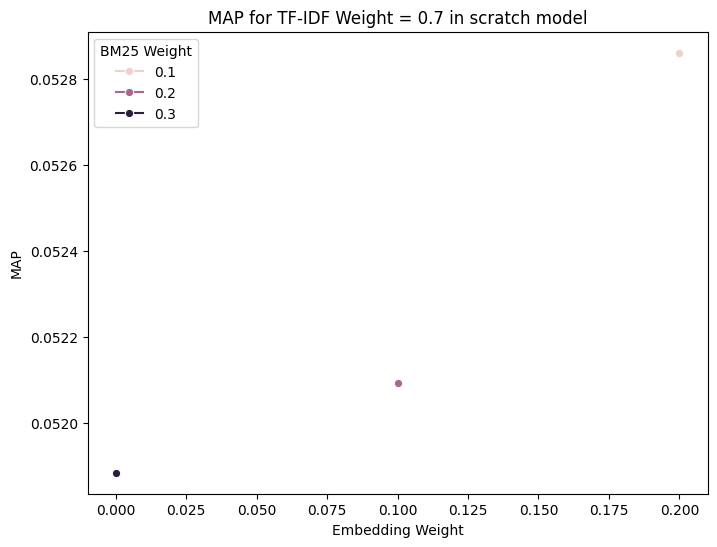

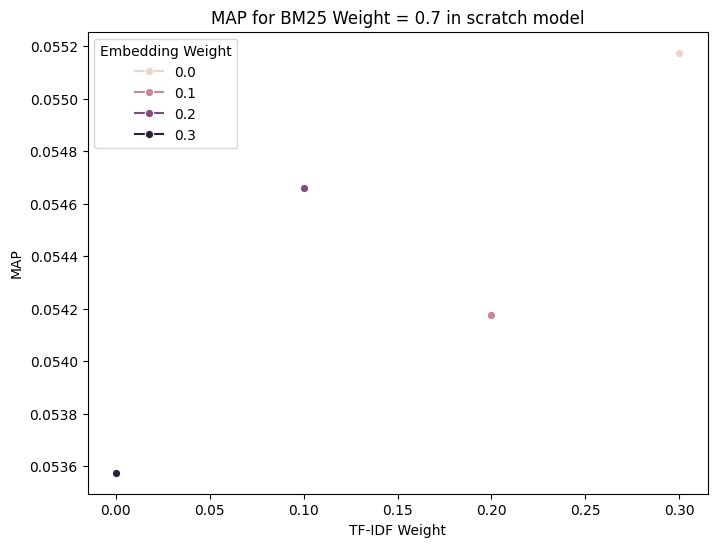

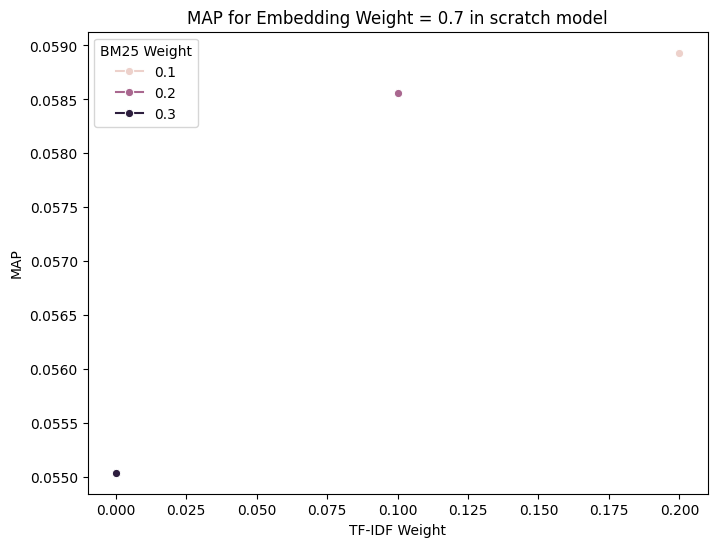

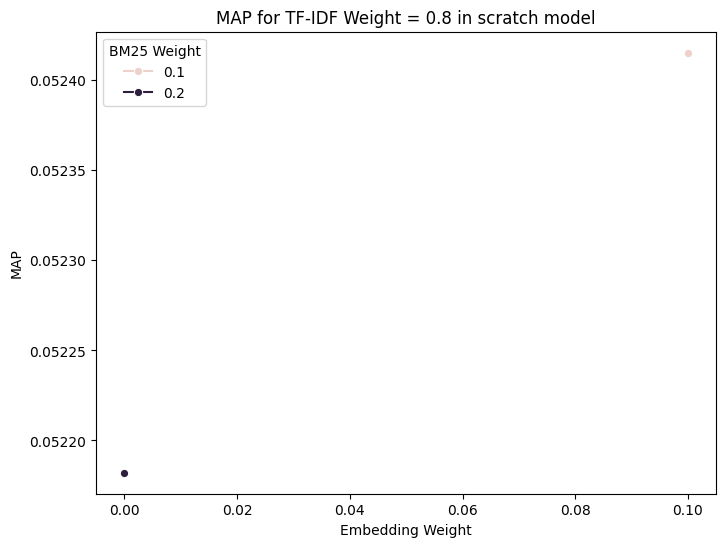

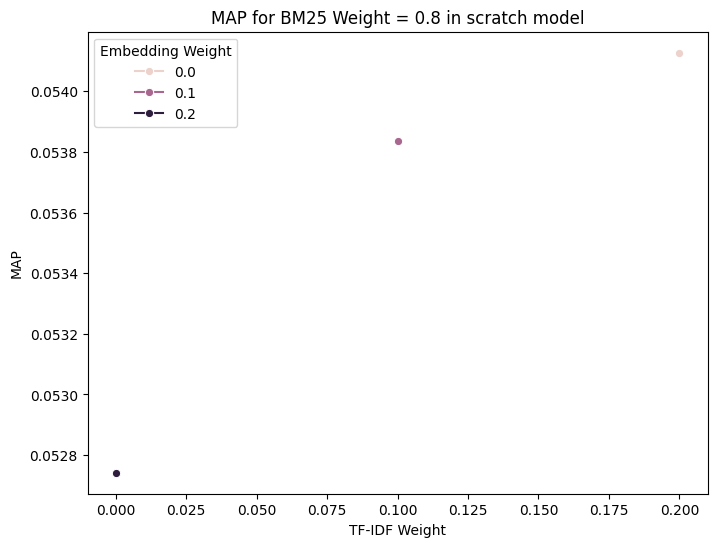

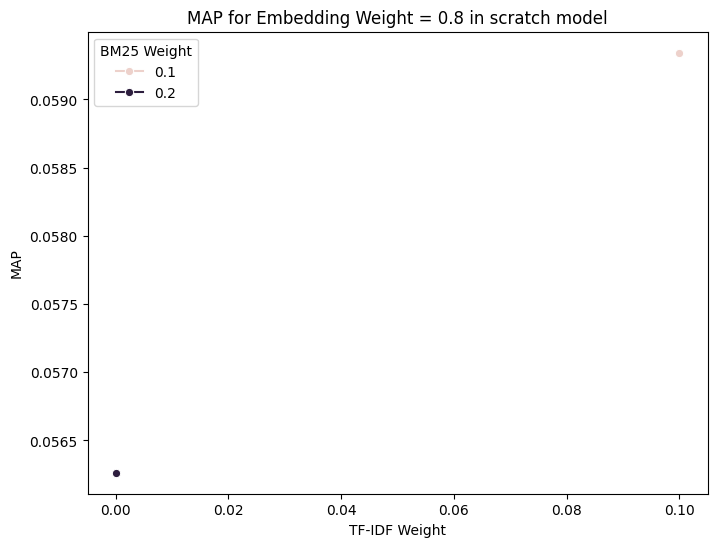

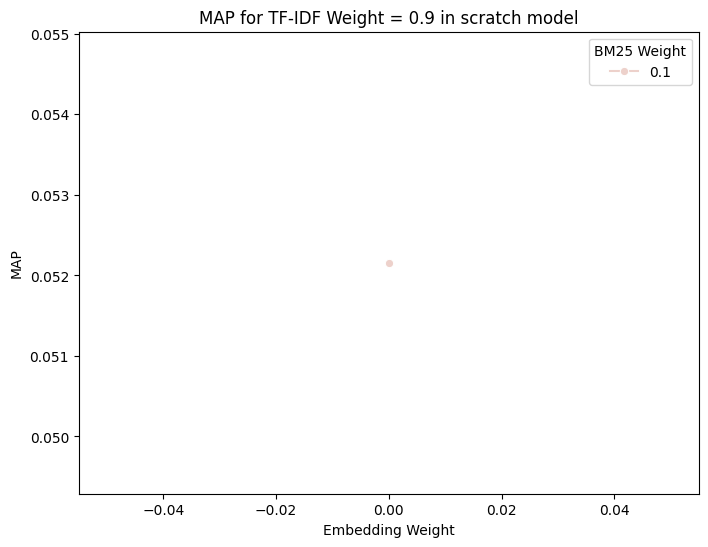

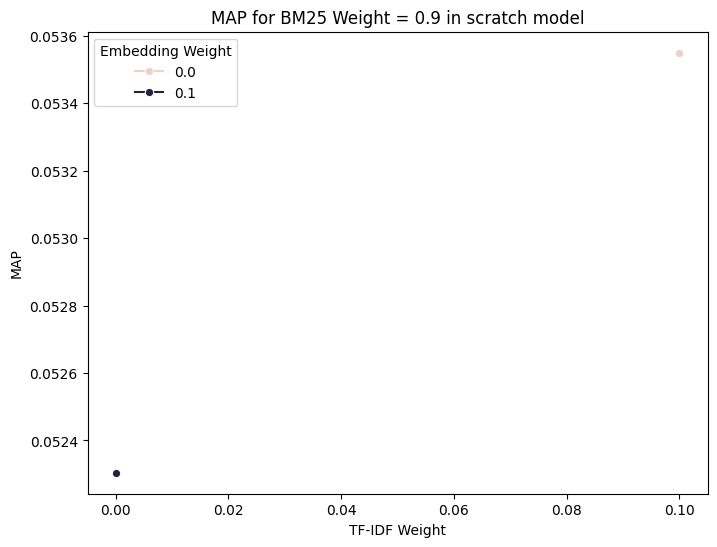

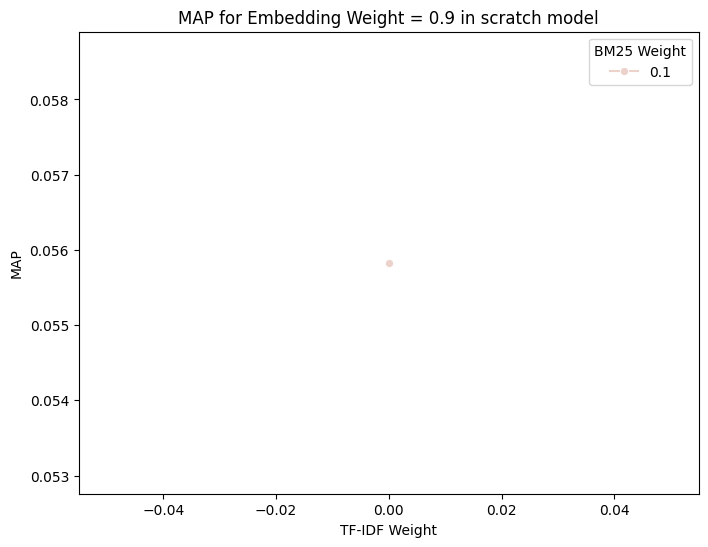

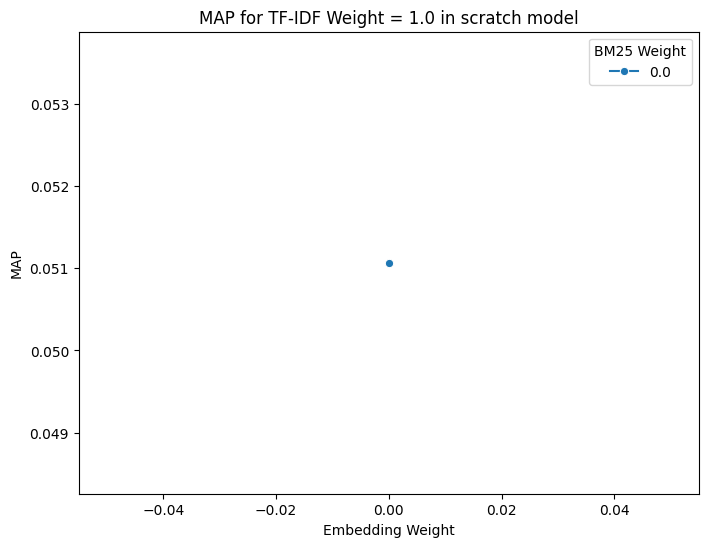

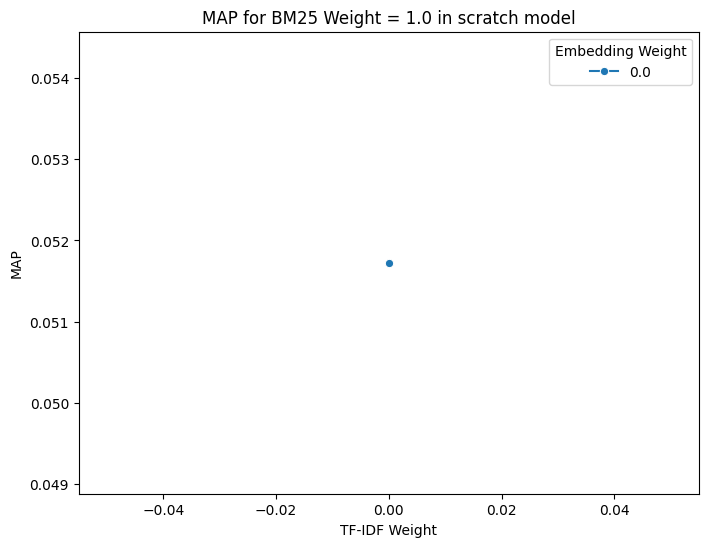

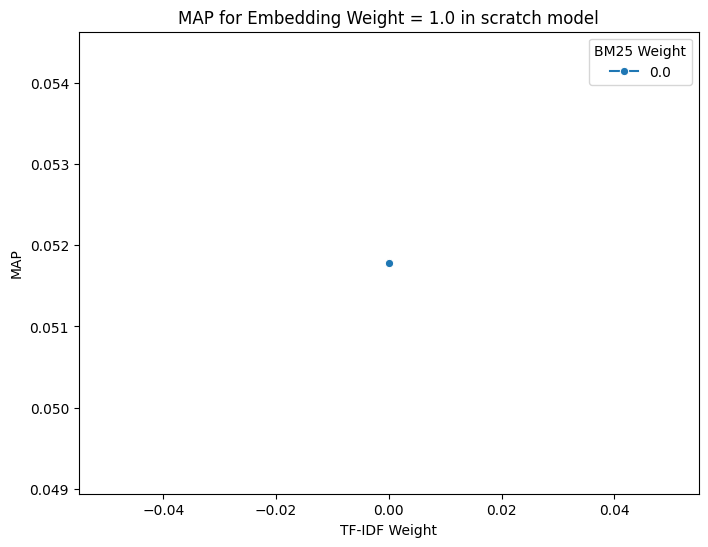

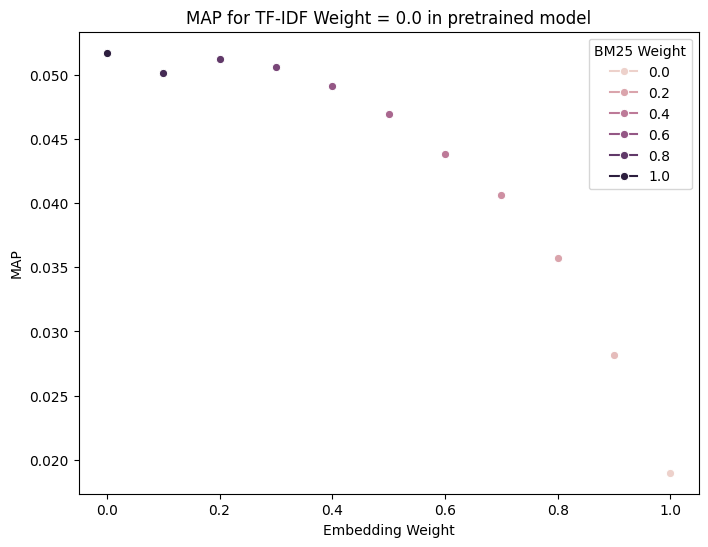

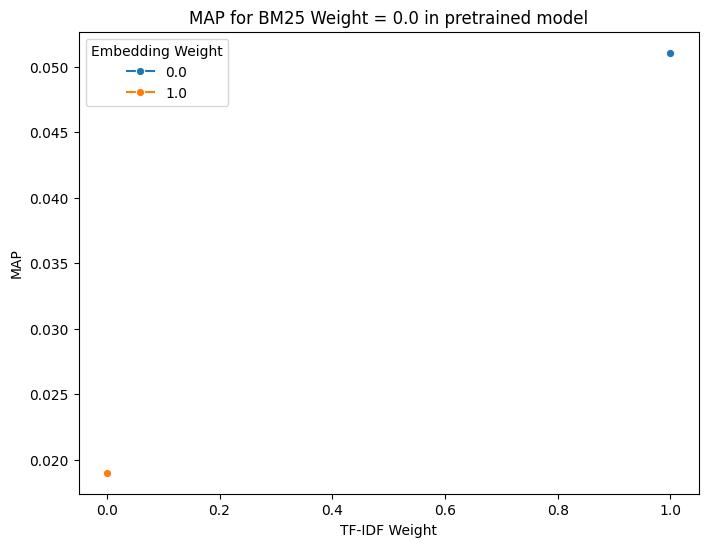

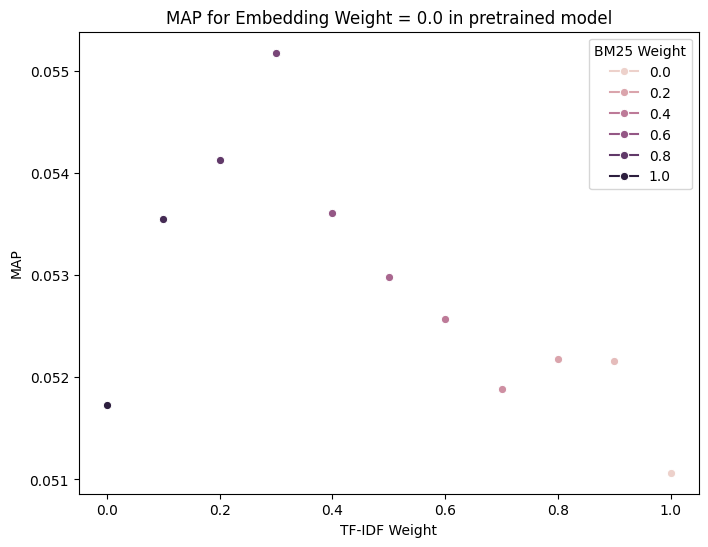

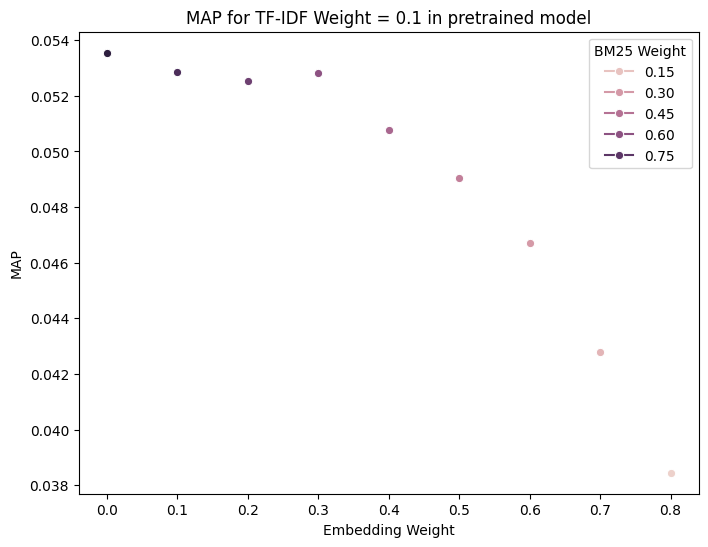

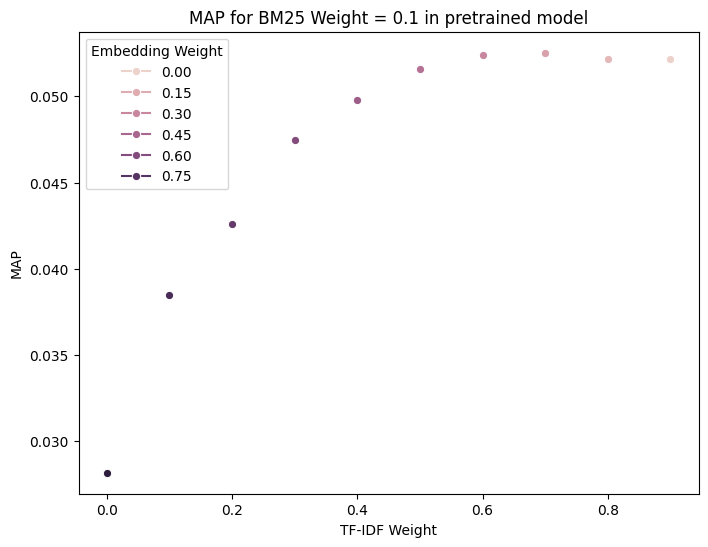

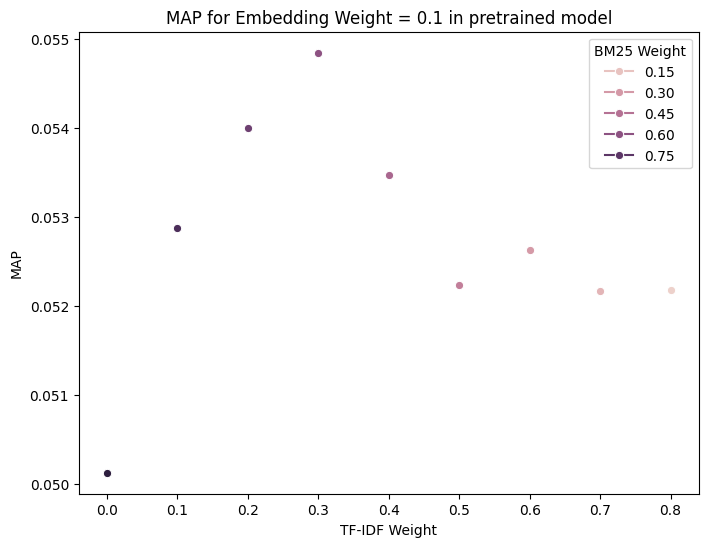

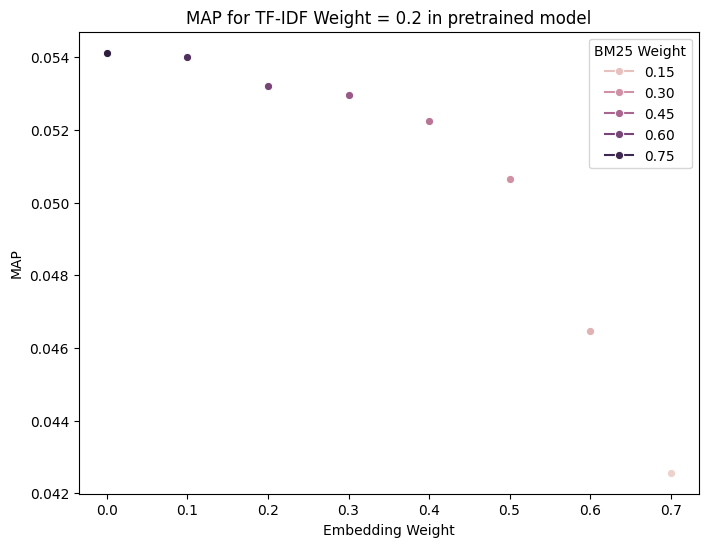

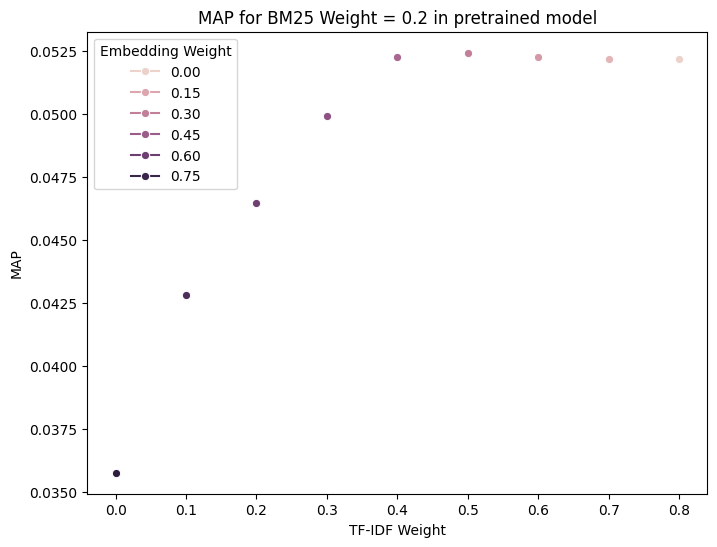

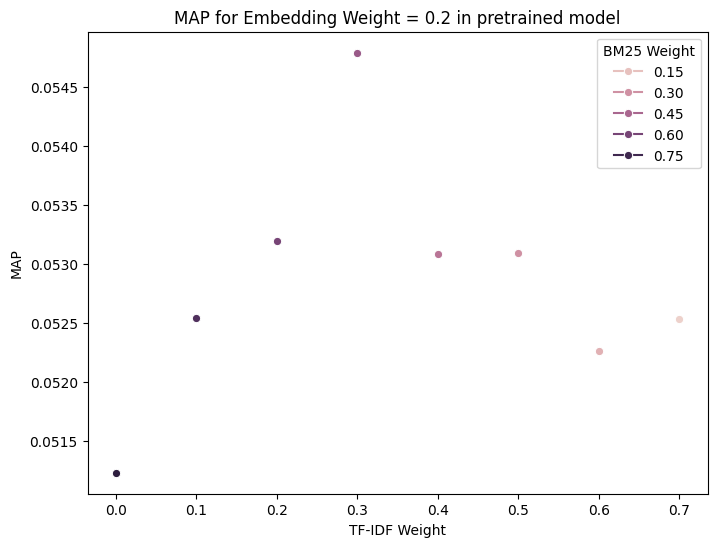

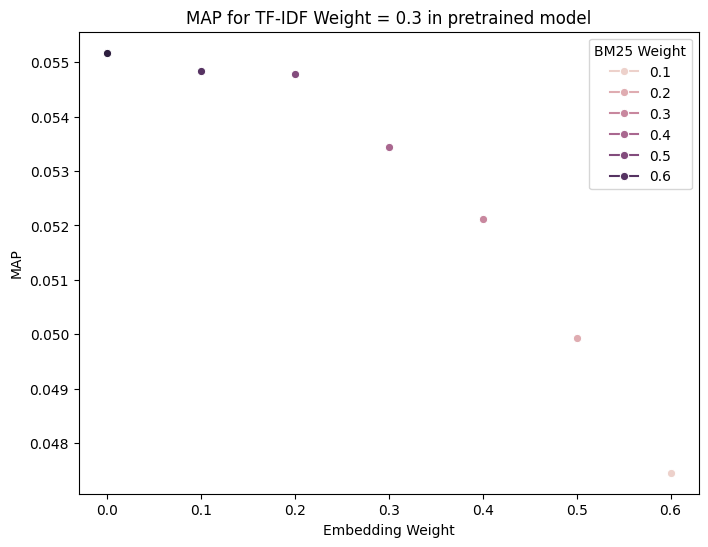

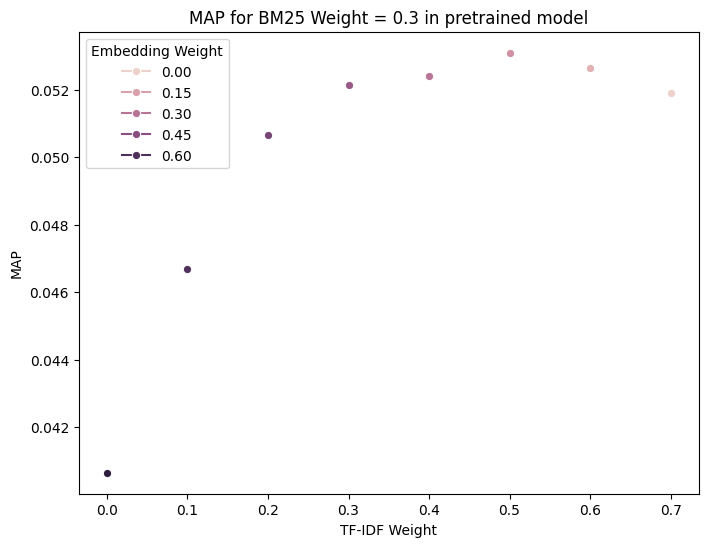

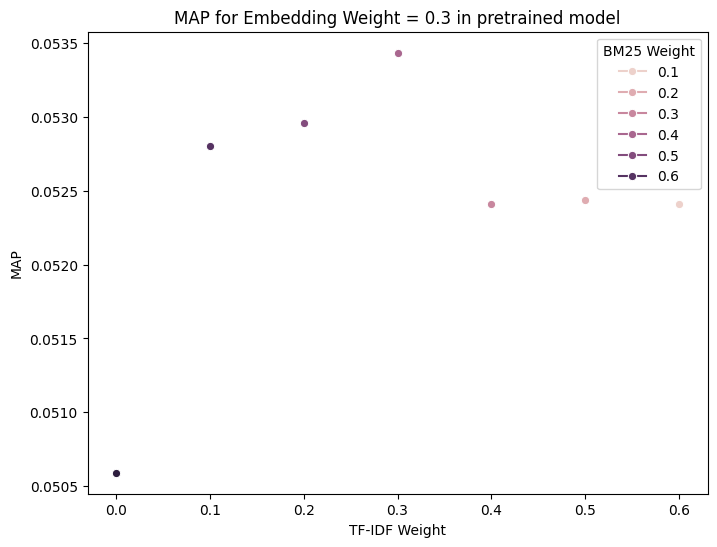

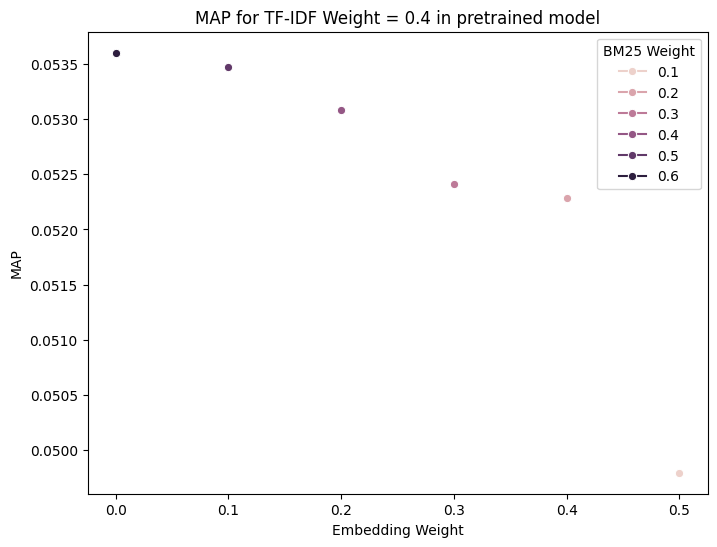

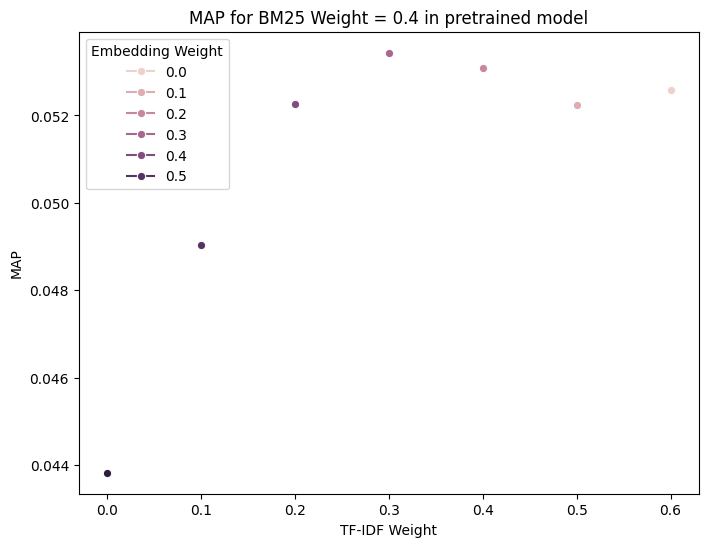

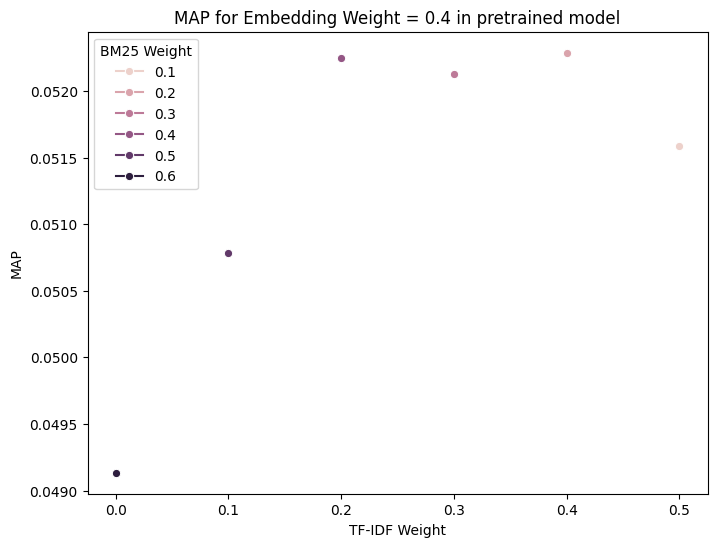

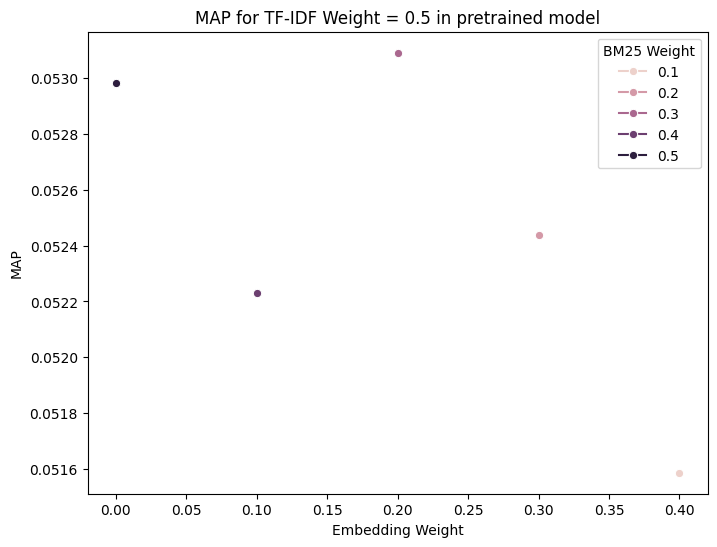

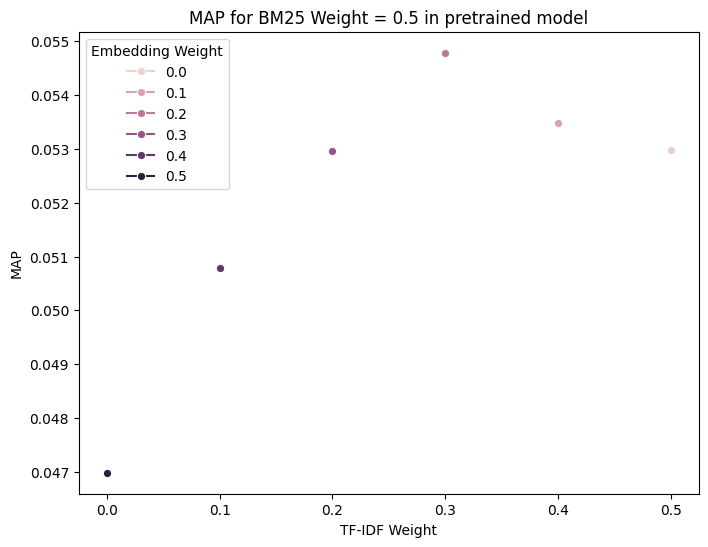

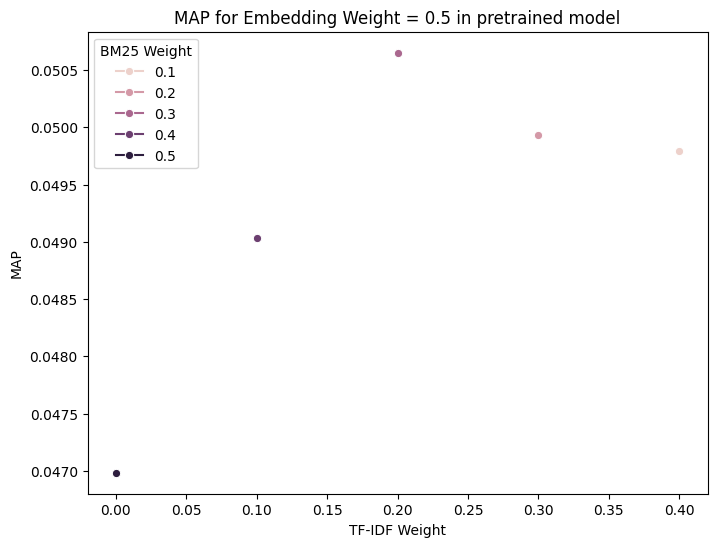

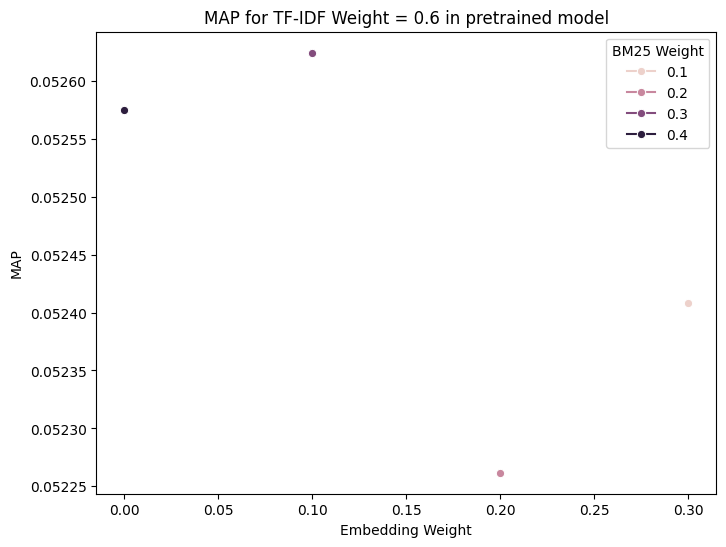

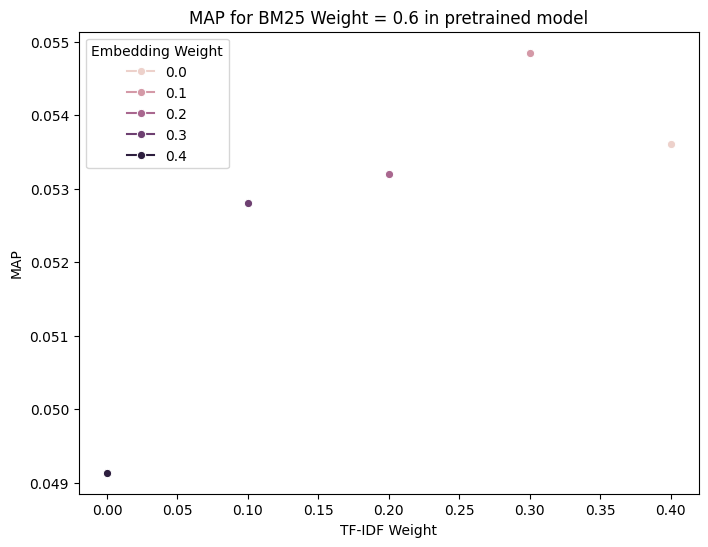

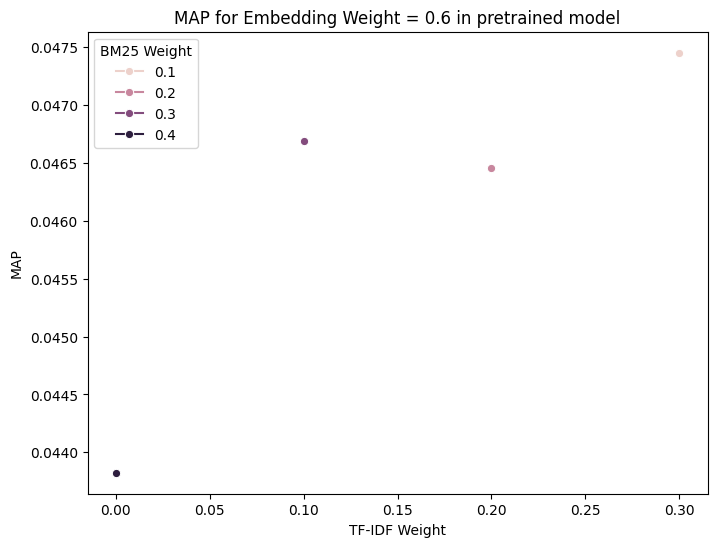

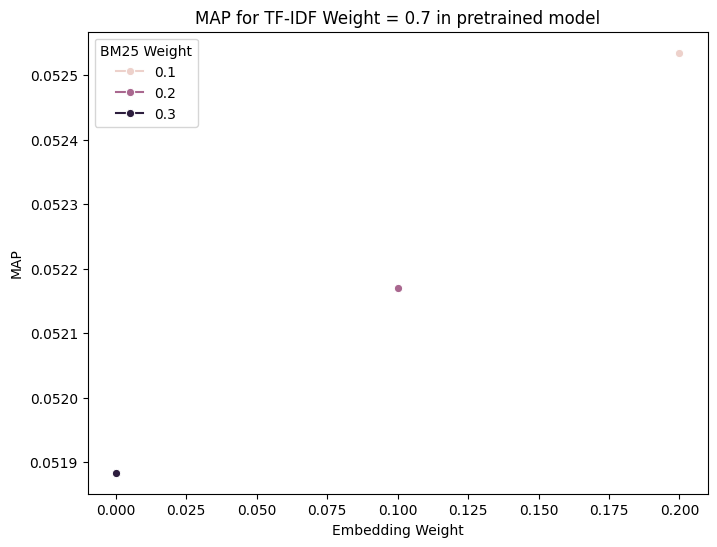

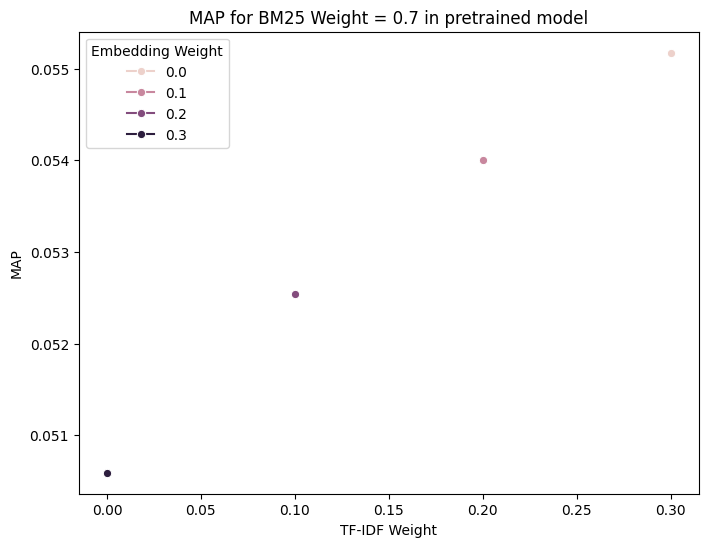

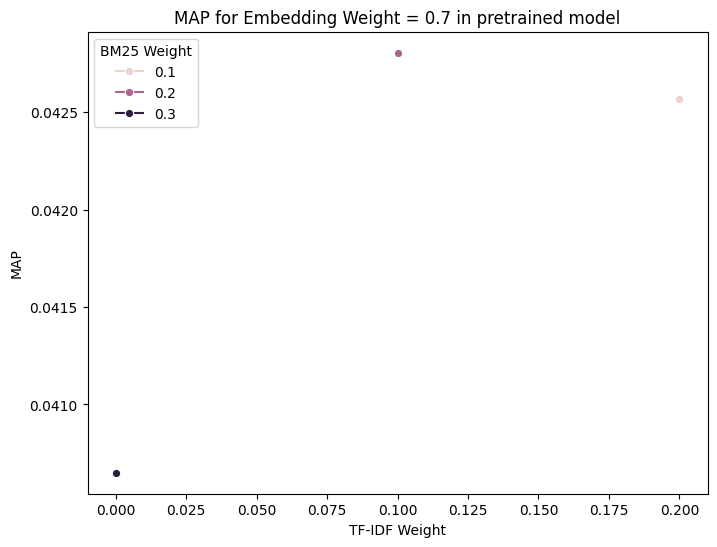

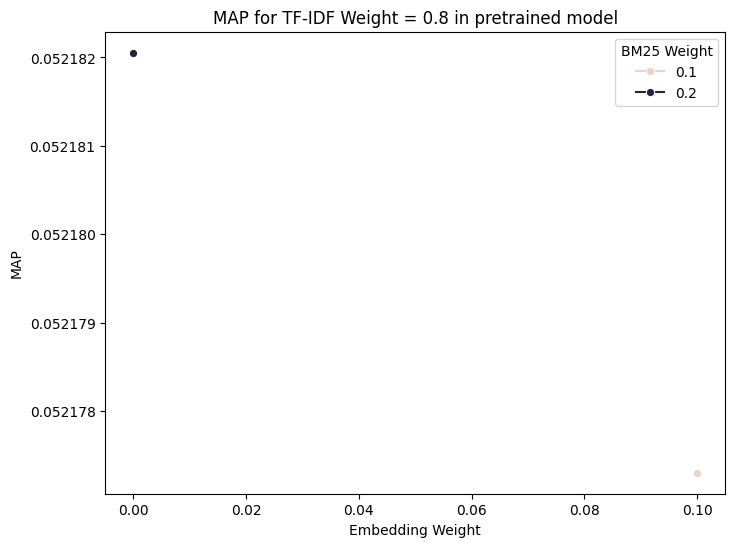

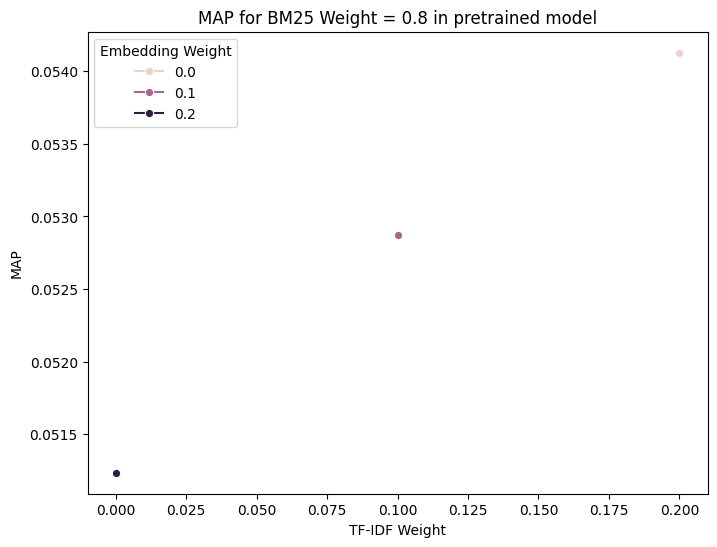

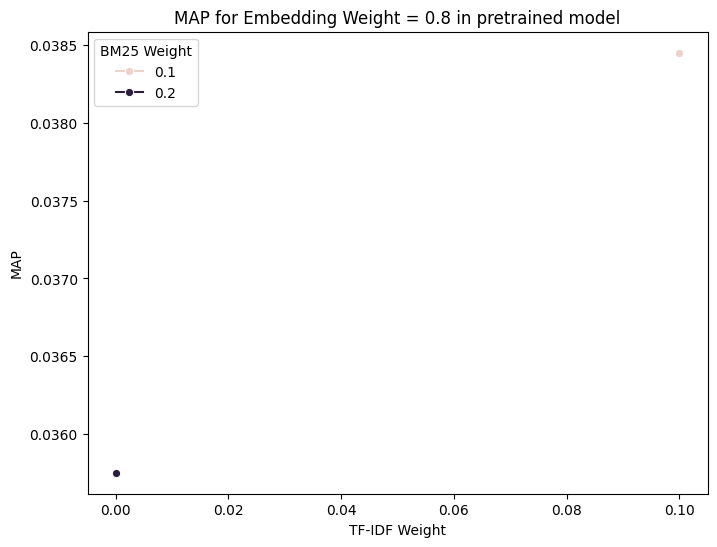

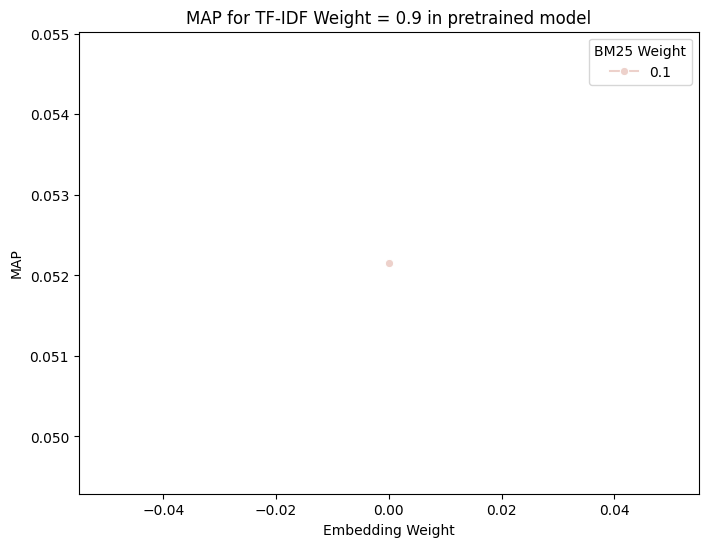

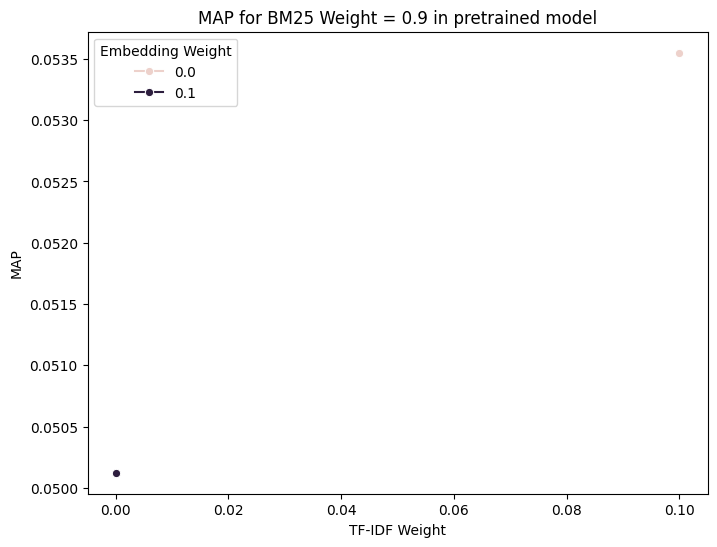

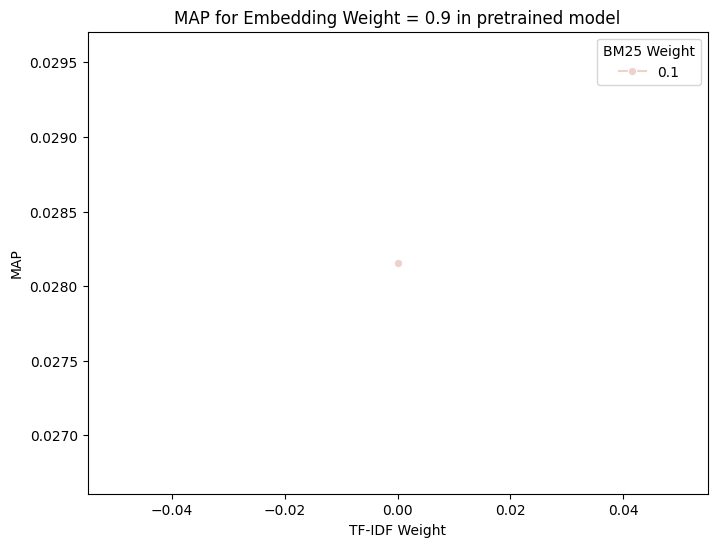

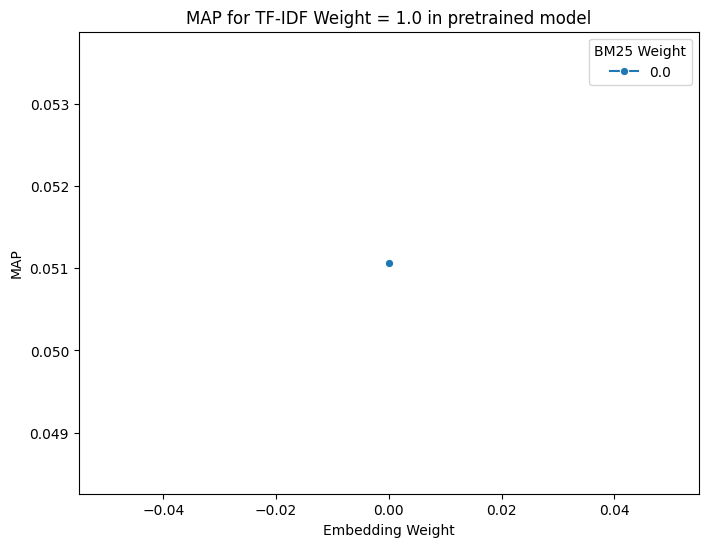

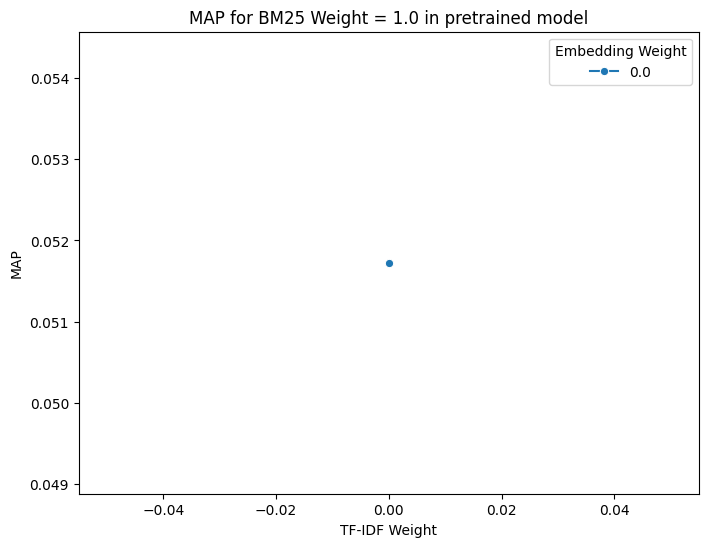

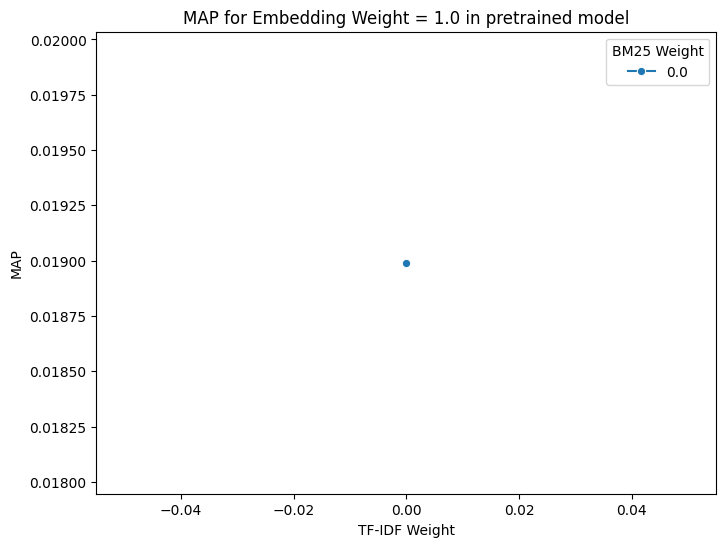

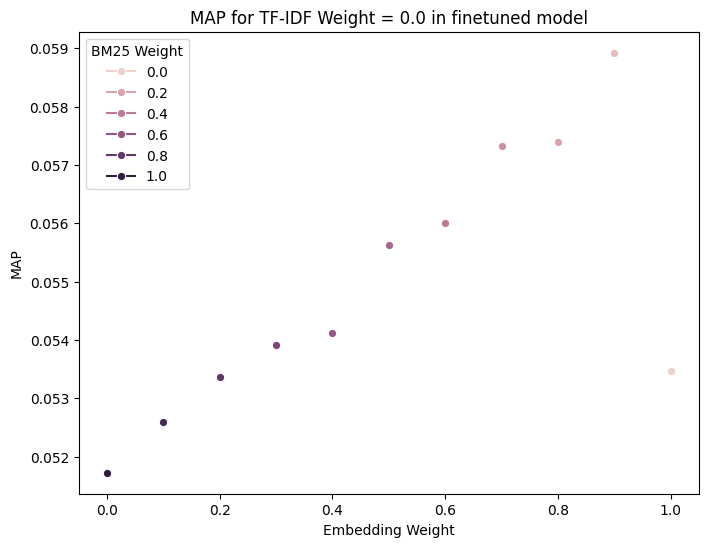

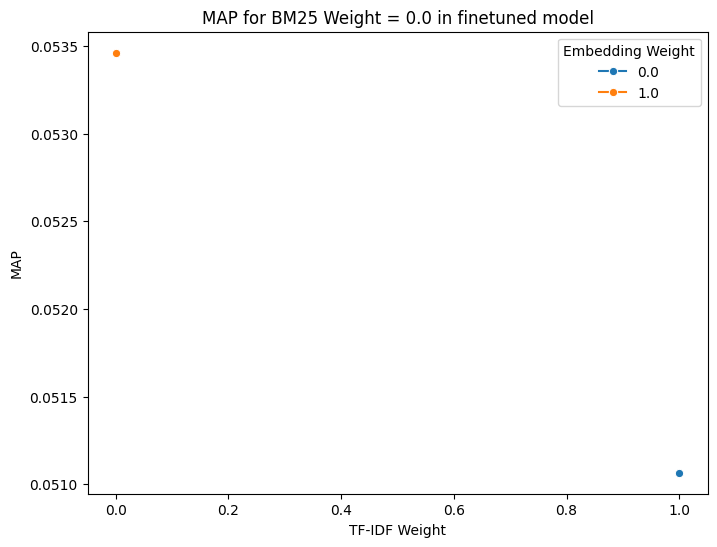

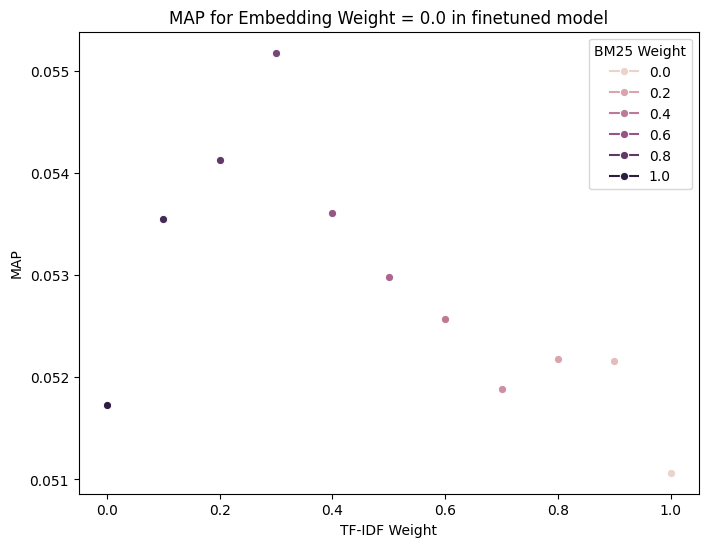

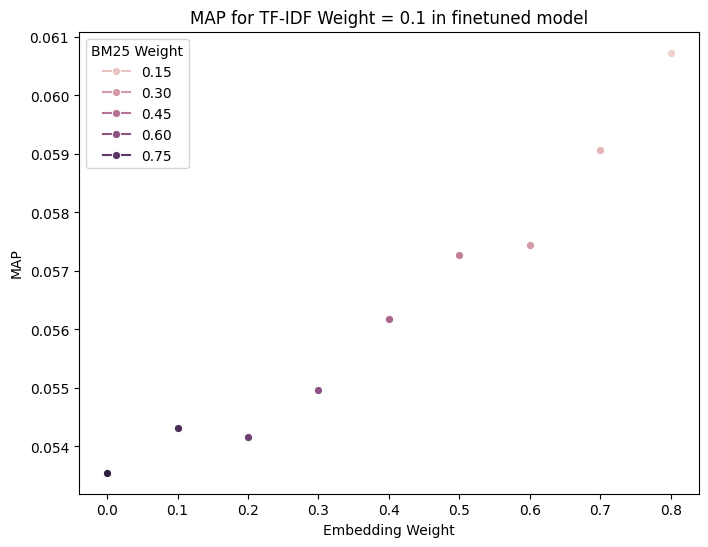

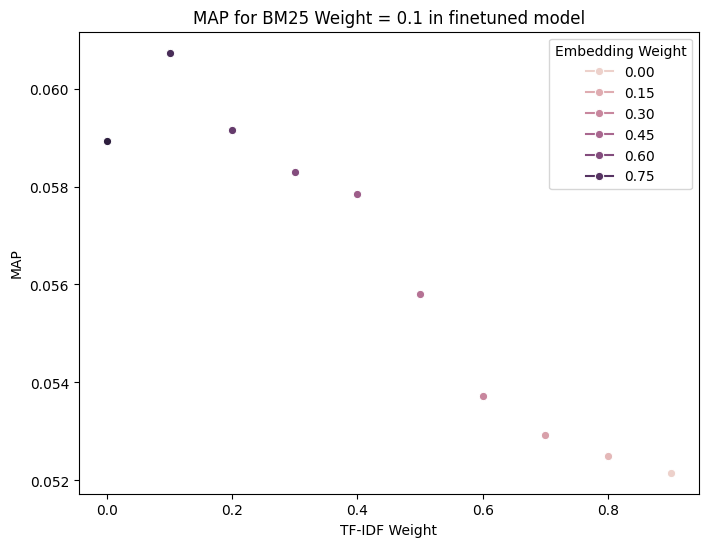

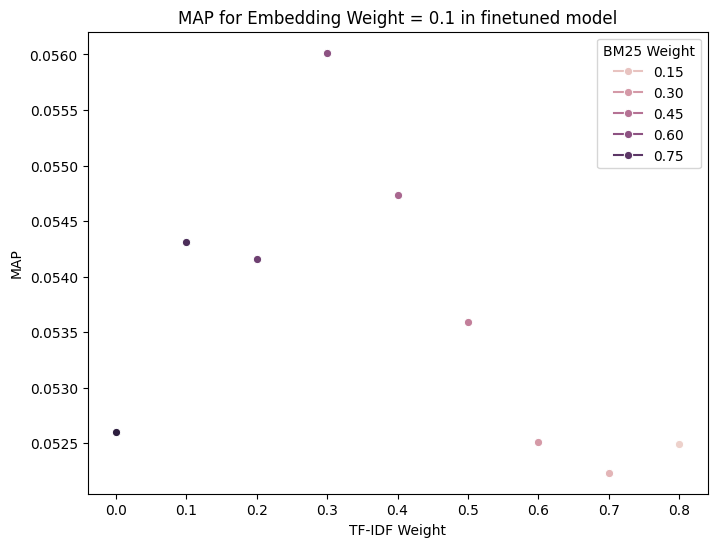

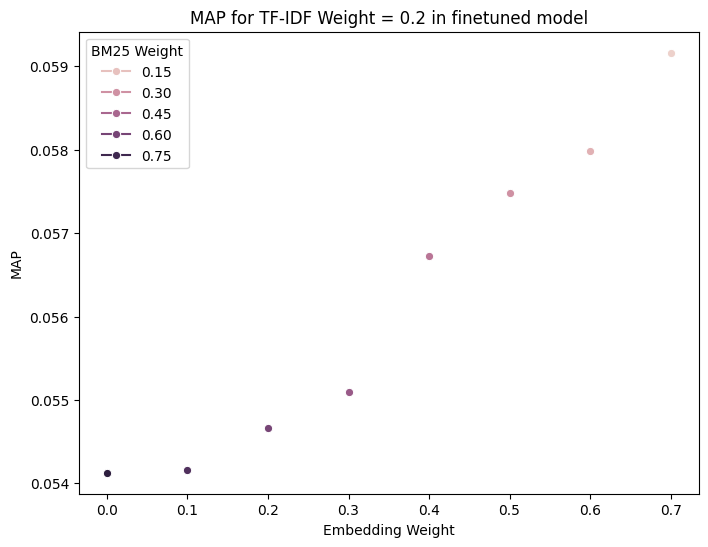

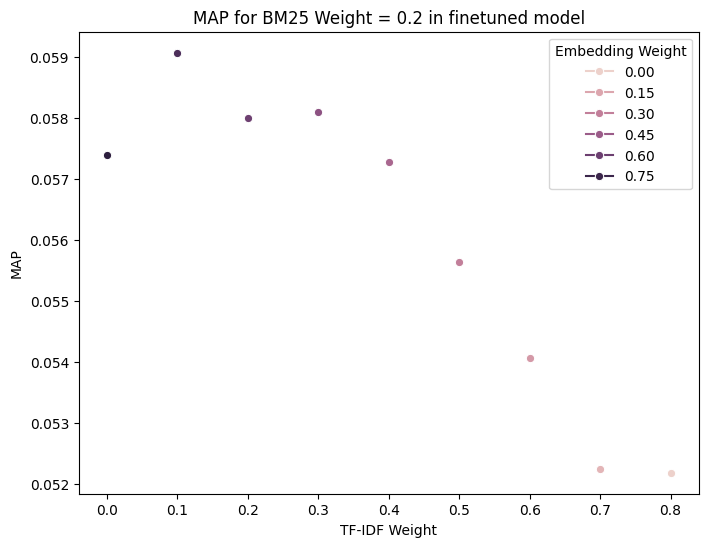

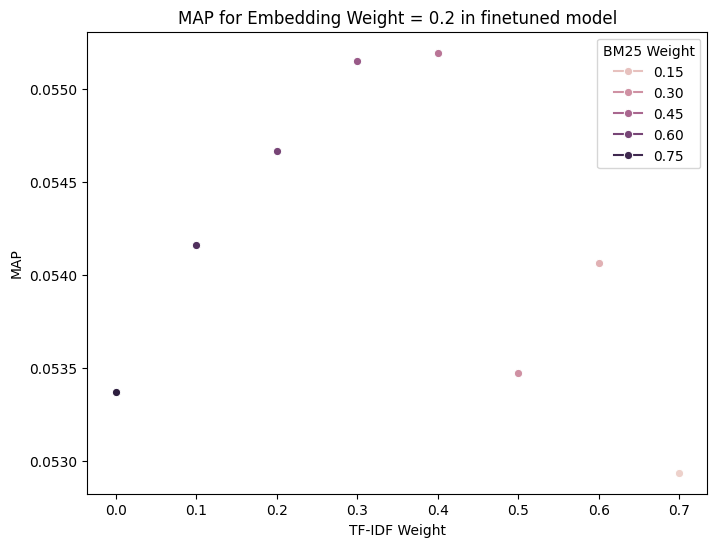

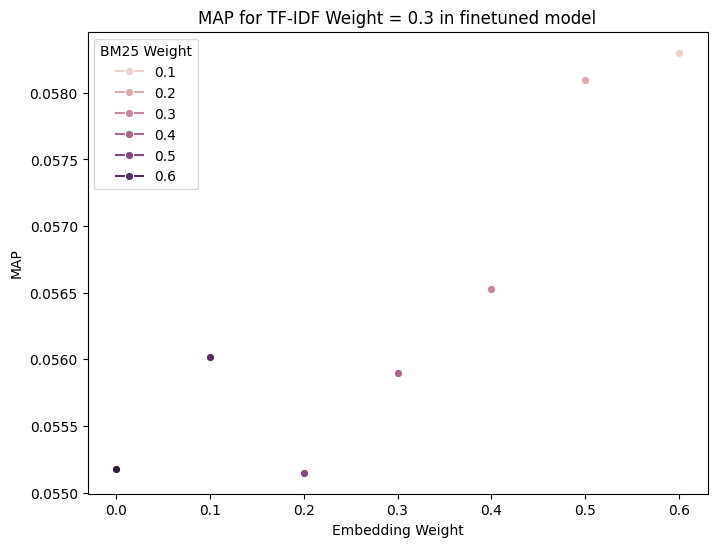

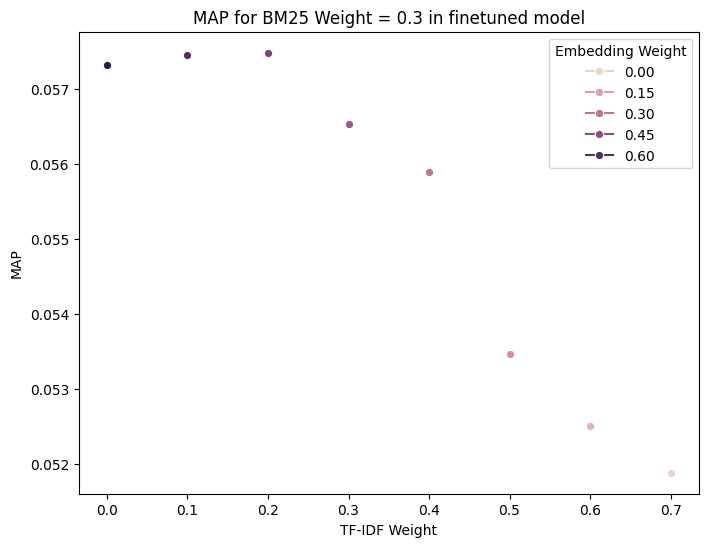

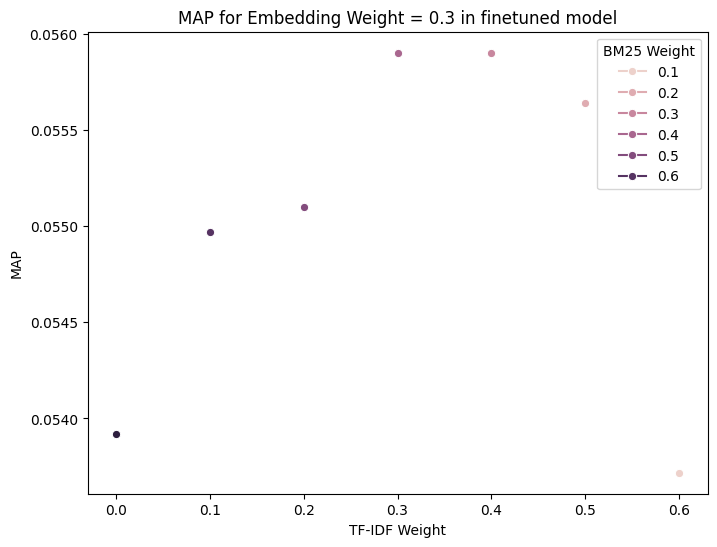

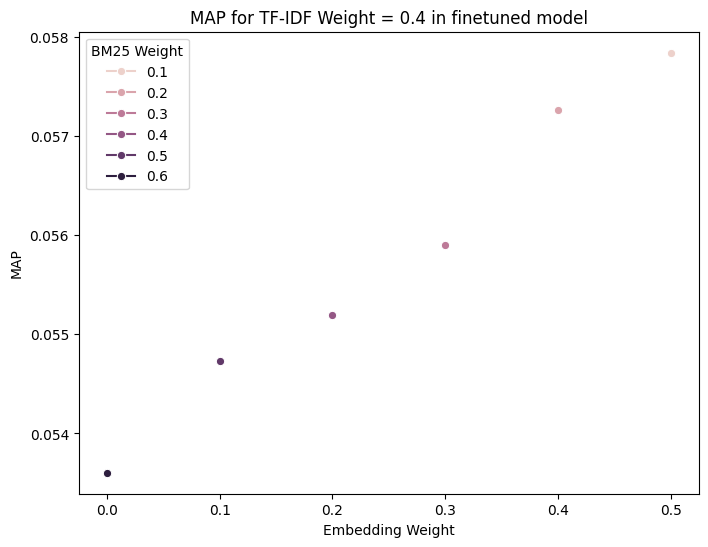

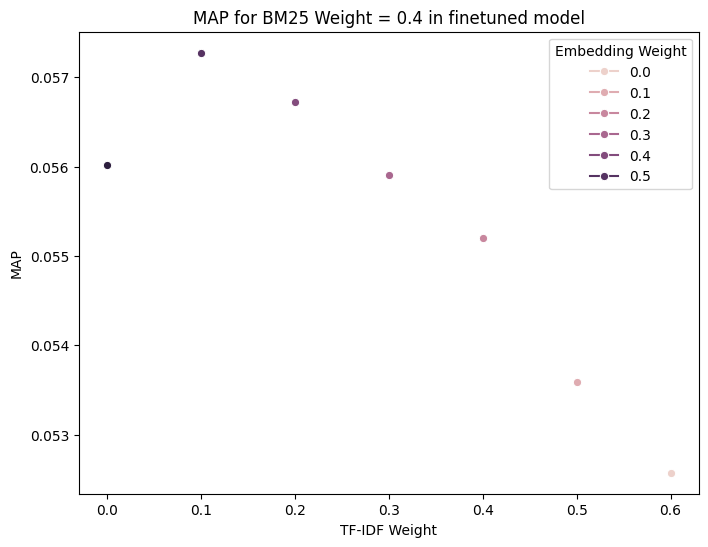

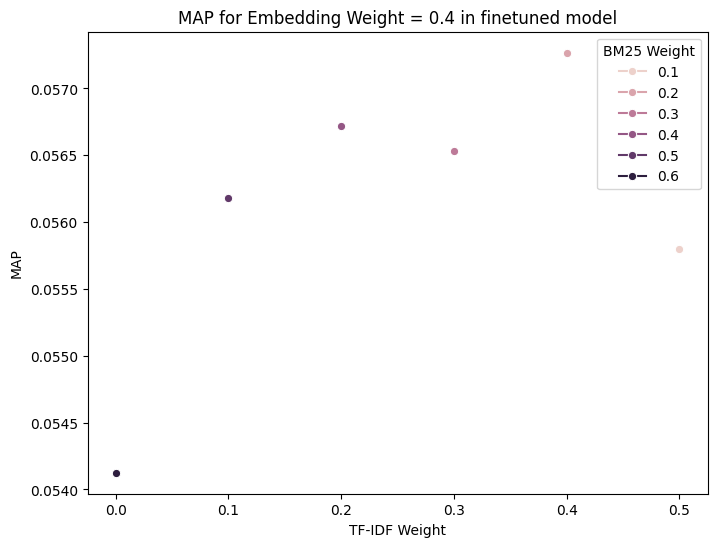

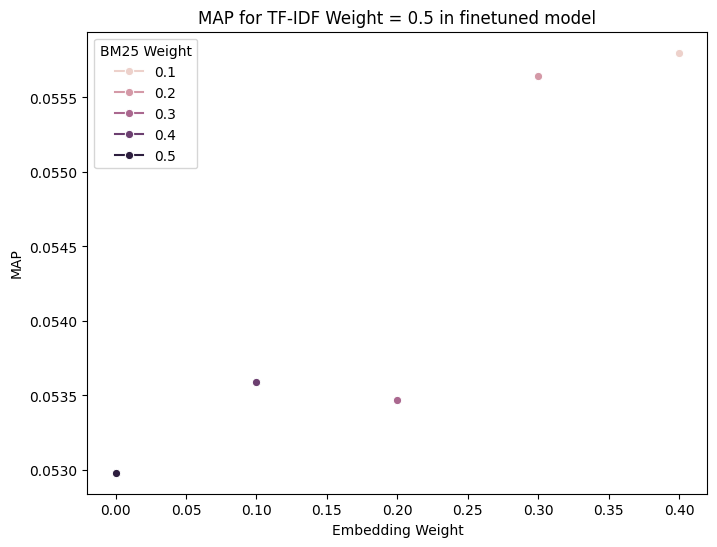

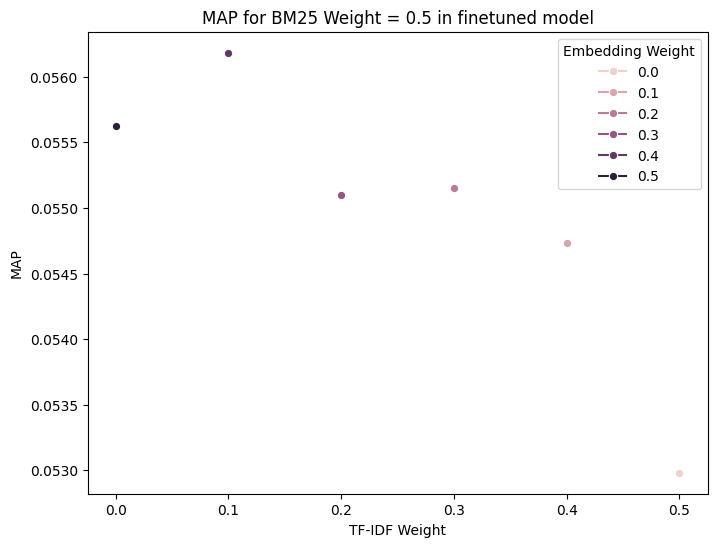

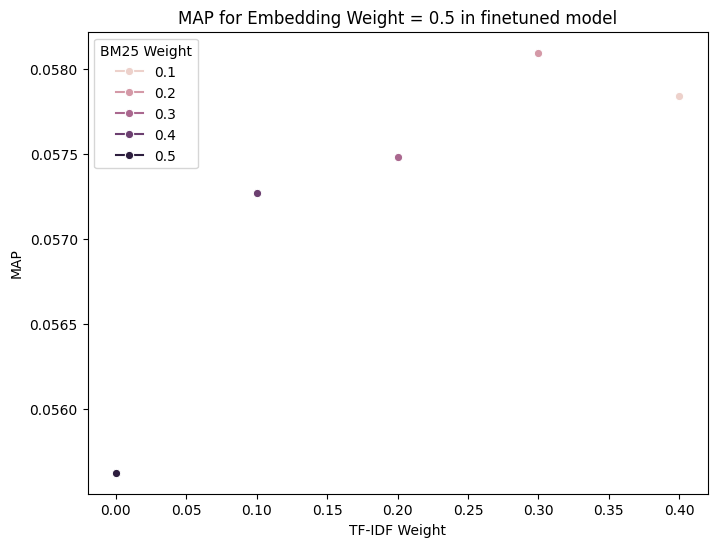

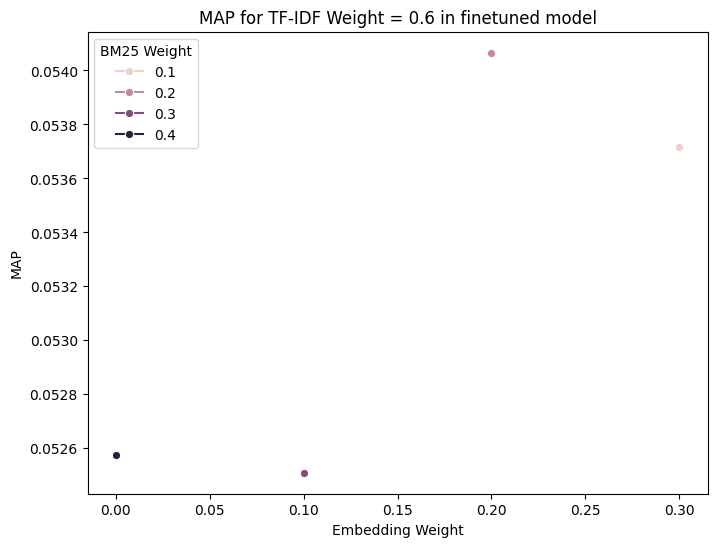

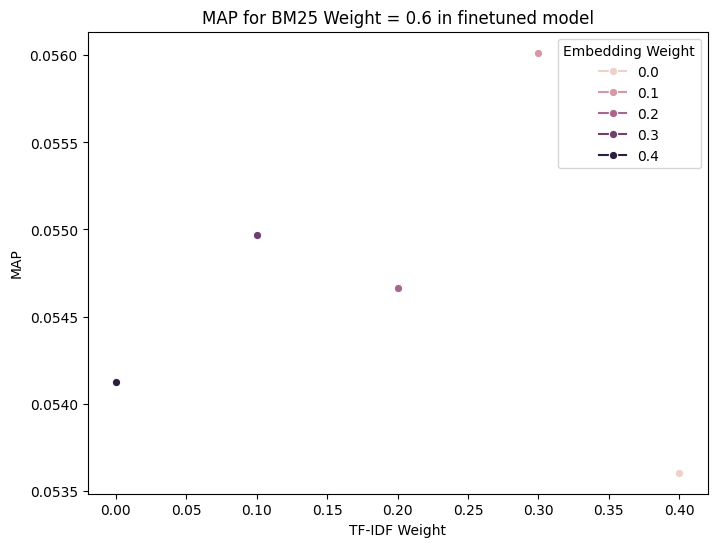

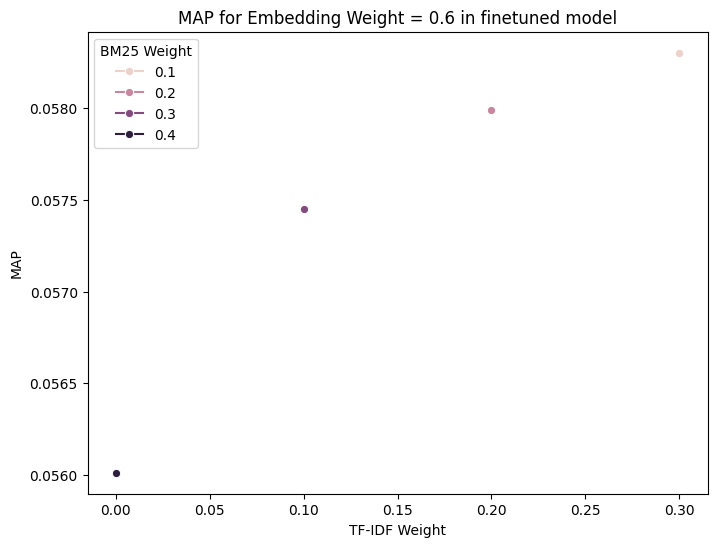

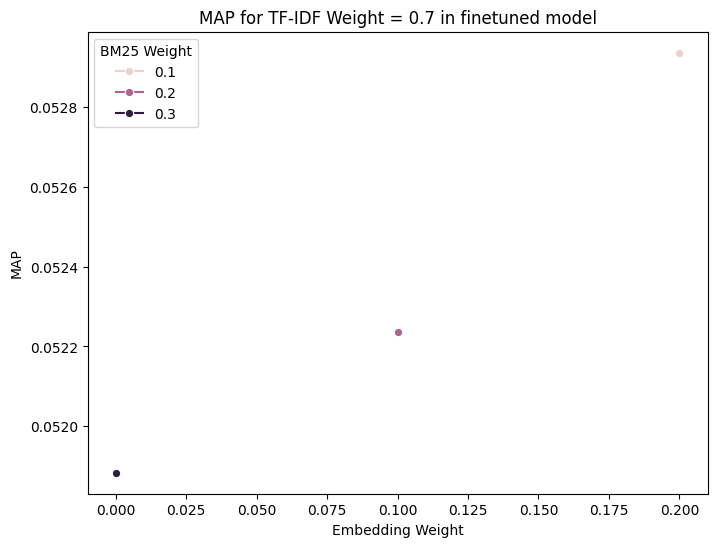

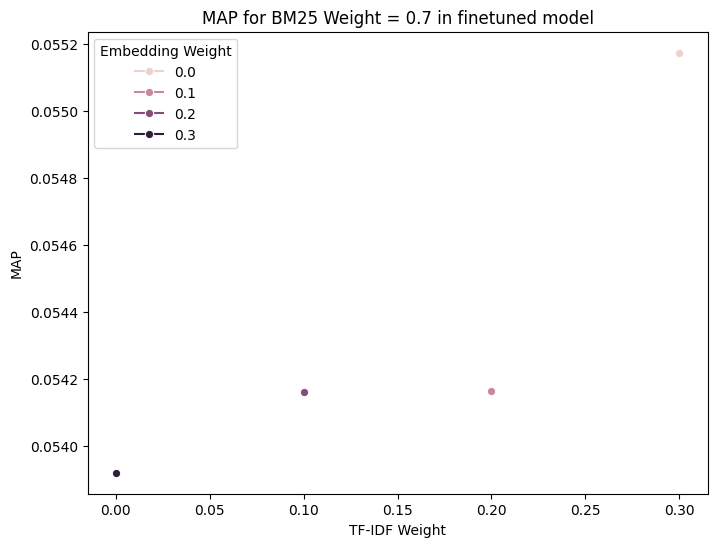

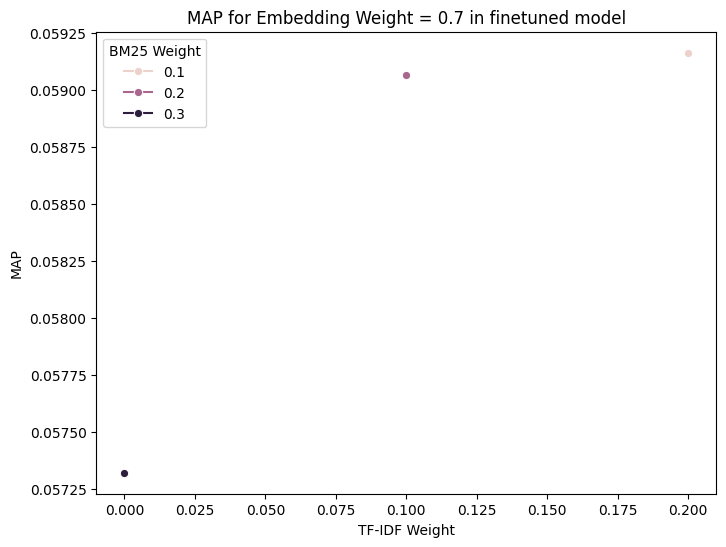

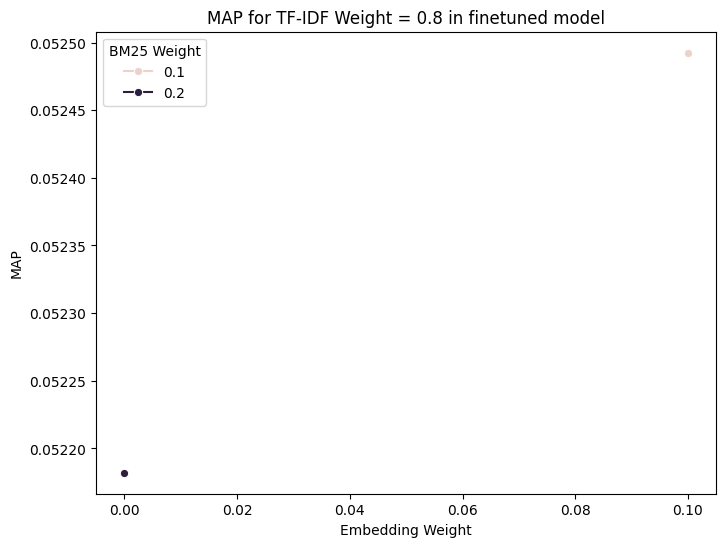

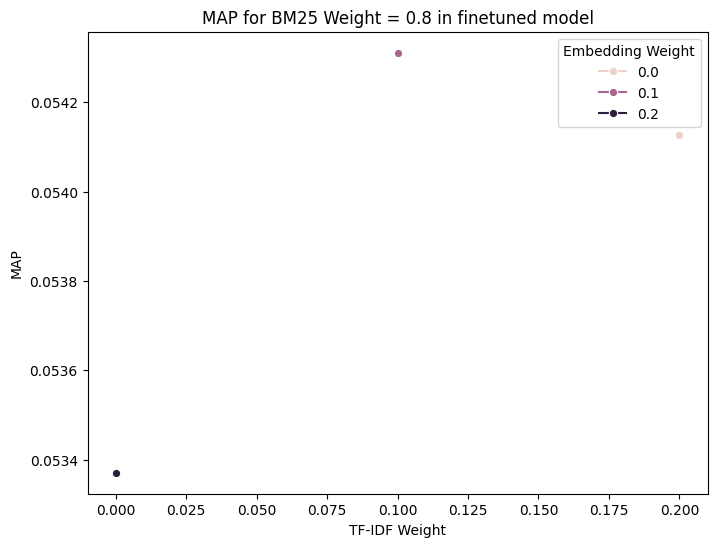

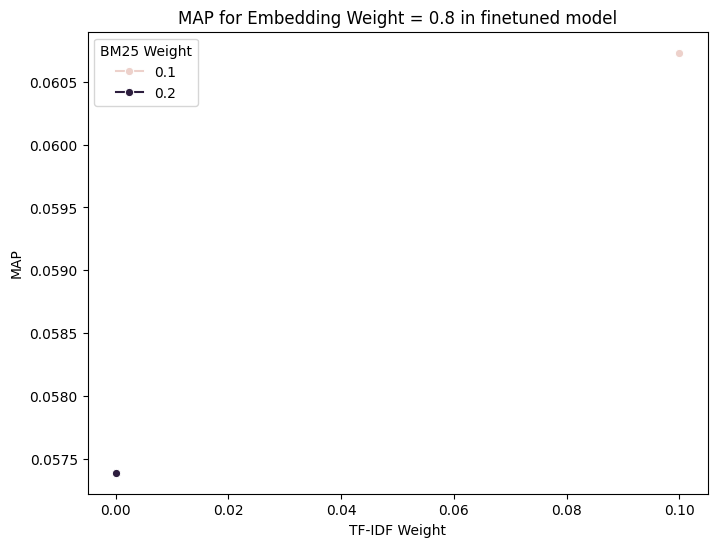

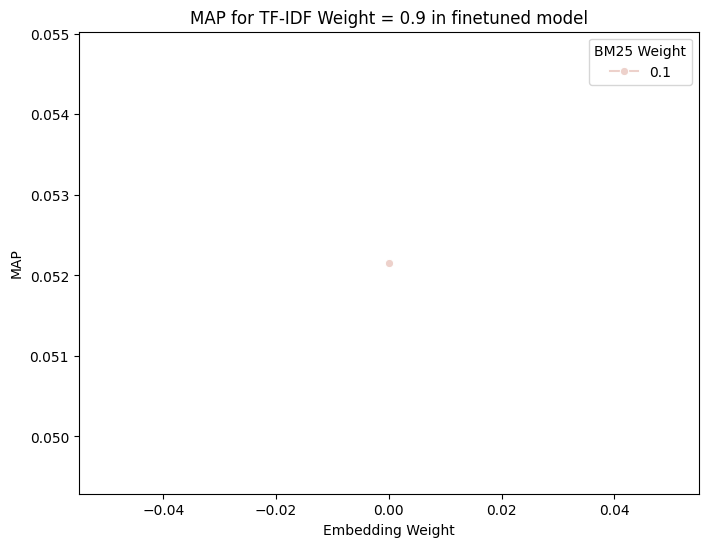

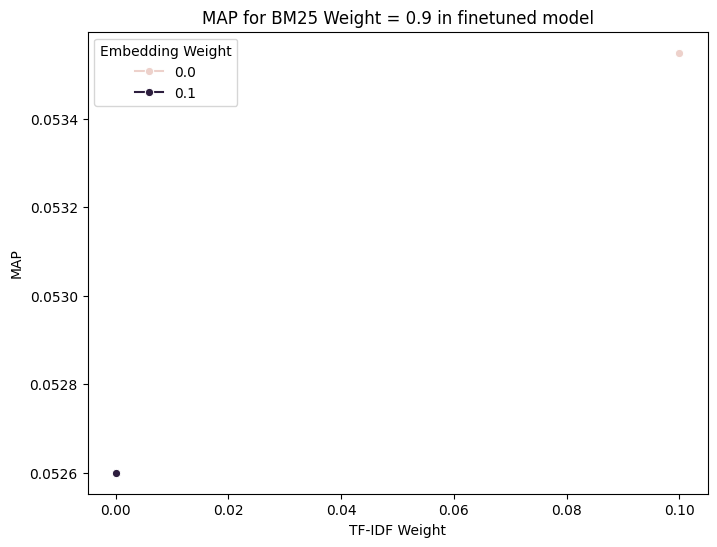

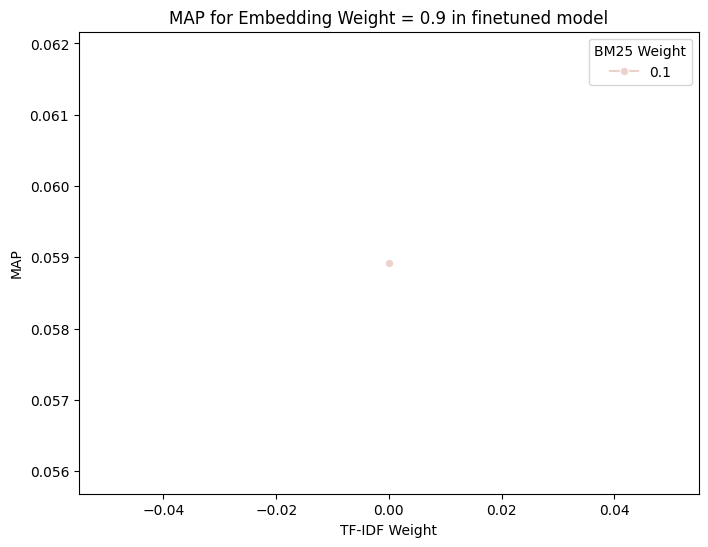

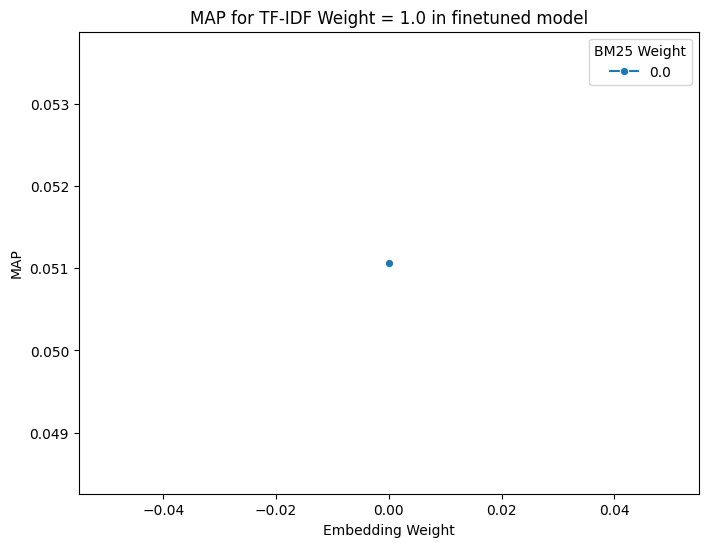

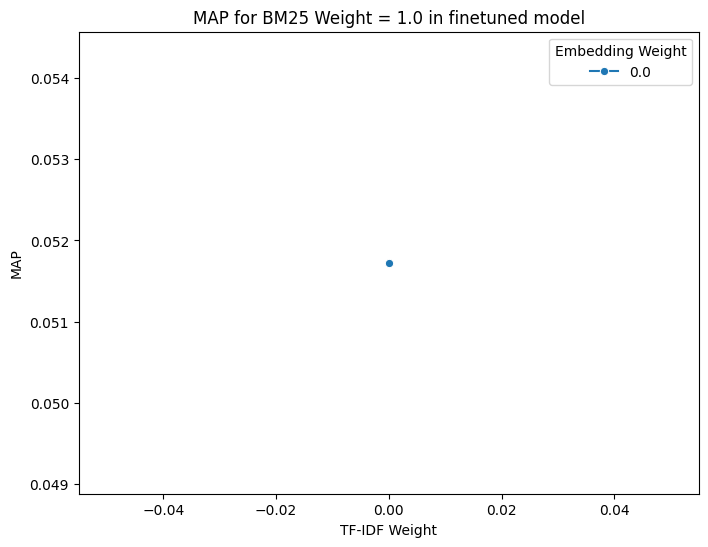

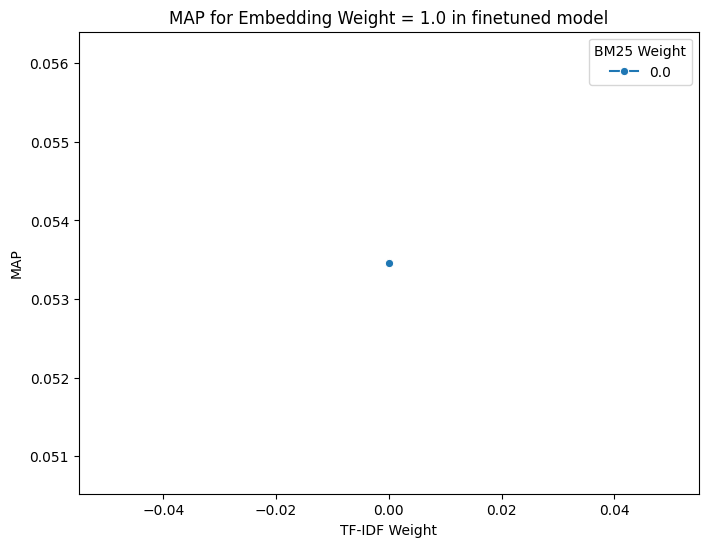

In [27]:
for model_df, model_name in zip(df_list, ["scratch", "pretrained", "finetuned"]):
    for weight in weights:
        plot_map_for_tfidf_fixed(model_df, weight)
        plot_map_for_bm25_fixed(model_df, weight)
        plot_map_for_embedding_fixed(model_df, weight)